In [363]:
pip install tensorflow

In [364]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split


In [365]:
# Load the Incident data
SHUdata = pd.read_csv('incident.csv')

print("Incident Overview:")
SHUdata.head(10)

Incident Overview:


,csg_sc,date_logged,generic_cls_n,inc_cat_n,inc_cause_n,inc_close_date,inc_major_n,inc_prior_n,inc_resolve_act,inc_resolve_due,inc_serious_n,IncidentID,internal_id,item_n,major_inc,prod_cls_n,product_n,serv_dept_n,status_enum,type_enum
0,COMMON,01/09/2020 11:42,IT Service,To be Qualified,SR_Completed,17/12/2020 15:49,Incident,Low,18/09/2020 05:30,05/10/2020 09:20,Minimum/Localised,10024315,Student,To Be Qualified,0,To Be Qualified,To Be Qualified,Service Desk,2,1
1,COMMON,01/09/2020 11:45,IT Service,To be Qualified,SR_Completed,17/12/2020 15:49,Incident,Low,18/09/2020 05:30,05/10/2020 11:04,Minimum/Localised,10024324,Student,To Be Qualified,0,To Be Qualified,To Be Qualified,Service Desk,2,1
2,COMMON,01/09/2020 11:45,IT Service,To be Qualified,SR_Completed,17/12/2020 16:22,Incident,Low,26/09/2020 05:30,09/10/2020 12:50,Minimum/Localised,10024326,Student,To Be Qualified,0,To Be Qualified,To Be Qualified,Service Desk,2,1
3,COMMON,01/09/2020 12:24,IT Service,To be Qualified,SR_Completed,17/12/2020 15:52,Incident,Low,19/09/2020 05:30,05/10/2020 10:12,Minimum/Localised,10024367,Student,To Be Qualified,0,To Be Qualified,To Be Qualified,Service Desk,2,1
4,COMMON,01/09/2020 12:48,IT Service,To be Qualified,SR_Completed,17/12/2020 15:53,Incident,Low,20/09/2020 05:30,02/10/2020 09:52,Minimum/Localised,10024466,Student,To Be Qualified,0,To Be Qualified,To Be Qualified,Service Desk,2,1
5,COMMON,01/09/2020 12:48,IT Service,To be Qualified,SR_Completed,17/12/2020 15:53,Incident,Low,20/09/2020 05:30,02/10/2020 09:28,Minimum/Localised,10024467,Student,To Be Qualified,0,To Be Qualified,To Be Qualified,Service Desk,2,1
6,COMMON,01/09/2020 12:54,IT Service,To be Qualified,SR_Completed,17/12/2020 16:20,Incident,Low,25/09/2020 05:30,05/10/2020 16:56,Minimum/Localised,10024492,Student,To Be Qualified,0,To Be Qualified,To Be Qualified,Service Desk,2,1
7,COMMON,01/09/2020 14:35,IT Service,To be Qualified,SR_Completed,17/12/2020 15:53,Incident,Low,21/09/2020 05:30,01/10/2020 13:35,Minimum/Localised,10024497,Student,To Be Qualified,0,To Be Qualified,To Be Qualified,Service Desk,2,1
8,COMMON,02/09/2020 11:58,IT Service,To be Qualified,SR_Completed,17/12/2020 16:20,Incident,Low,25/09/2020 05:30,06/10/2020 08:38,Minimum/Localised,10024631,Student,To Be Qualified,0,To Be Qualified,To Be Qualified,Service Desk,2,1
9,COMMON,02/09/2020 14:51,IT Service,To be Qualified,SR_Completed,17/12/2020 16:23,Incident,Low,28/09/2020 05:30,02/10/2020 12:28,Minimum/Localised,10024715,Student,To Be Qualified,0,To Be Qualified,To Be Qualified,Service Desk,2,1


In [366]:
SHUdata.shape

(81271, 20)

In [367]:
SHUdata.describe()

,IncidentID,major_inc,status_enum,type_enum
count,8.127100e+04,81271.000000,81271.000000,81271.0
mean,1.011428e+07,0.000406,2.052417,1.0
std,6.182574e+04,0.020147,0.222868,0.0
min,1.002403e+07,0.000000,2.000000,1.0
25%,1.005946e+07,0.000000,2.000000,1.0
50%,1.010444e+07,0.000000,2.000000,1.0
75%,1.016646e+07,0.000000,2.000000,1.0
max,1.023770e+07,1.000000,3.000000,1.0


In [368]:
# Filter out pending incidents
SHUdata = SHUdata[SHUdata['status_enum'] != 3]

# Filter out events type that are not Incidents
SHUdata = SHUdata[SHUdata['type_enum'] == 1]

# Display the modified dataset
SHUdata.head

<bound method NDFrame.head of        csg_sc       date_logged generic_cls_n        inc_cat_n   inc_cause_n  \
0      COMMON  01/09/2020 11:42    IT Service  To be Qualified  SR_Completed   
1      COMMON  01/09/2020 11:45    IT Service  To be Qualified  SR_Completed   
2      COMMON  01/09/2020 11:45    IT Service  To be Qualified  SR_Completed   
3      COMMON  01/09/2020 12:24    IT Service  To be Qualified  SR_Completed   
4      COMMON  01/09/2020 12:48    IT Service  To be Qualified  SR_Completed   
...       ...               ...           ...              ...           ...   
81266  COMMON  18/10/2023 05:38    IT Service  INC_Logon Issue  SR_Completed   
81267  COMMON  18/10/2023 10:48    IT Service  INC_Logon Issue  SR_Completed   
81268  COMMON  18/10/2023 11:16    IT Service  INC_Logon Issue  SR_Completed   
81269  COMMON  18/10/2023 13:57    IT Service  INC_Logon Issue  SR_Completed   
81270  COMMON  18/10/2023 22:06    IT Service  INC_Logon Issue  SR_Completed   

         

In [369]:
SHUdata.shape

(77011, 20)

In [370]:
SHUdata.describe() 

,IncidentID,major_inc,status_enum,type_enum
count,7.701100e+04,77011.000000,77011.0,77011.0
mean,1.011277e+07,0.000429,2.0,1.0
std,6.166368e+04,0.020696,0.0,0.0
min,1.002403e+07,0.000000,2.0,1.0
25%,1.005814e+07,0.000000,2.0,1.0
50%,1.010216e+07,0.000000,2.0,1.0
75%,1.016463e+07,0.000000,2.0,1.0
max,1.023770e+07,1.000000,2.0,1.0


In [371]:
#Check the dimension of the data
SHUdata.shape

(77011, 20)

In [372]:
#Get information about the data types of each column and missing values
print("Data Shape")
print(SHUdata.info())
print()

Data Shape
<class 'pandas.core.frame.DataFrame'>
Index: 77011 entries, 0 to 81270
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   csg_sc           77011 non-null  object
 1   date_logged      77011 non-null  object
 2   generic_cls_n    77011 non-null  object
 3   inc_cat_n        77011 non-null  object
 4   inc_cause_n      76977 non-null  object
 5   inc_close_date   77011 non-null  object
 6   inc_major_n      77011 non-null  object
 7   inc_prior_n      77011 non-null  object
 8   inc_resolve_act  77011 non-null  object
 9   inc_resolve_due  74702 non-null  object
 10  inc_serious_n    77011 non-null  object
 11  IncidentID       77011 non-null  int64 
 12  internal_id      64227 non-null  object
 13  item_n           77011 non-null  object
 14  major_inc        77011 non-null  int64 
 15  prod_cls_n       77011 non-null  object
 16  product_n        77011 non-null  object
 17  serv_dept_n      77011 no

In [373]:
#List of column names to drop
columns_to_drop =['csg_sc', 'inc_close_date', 'generic_cls_n', 'serv_dept_n', 'internal_id', 'inc_serious_n', 'status_enum', 'major_inc', 'type_enum']

#Drop the specified columns
SHUdata = SHUdata.drop(columns=columns_to_drop)
SHUdata.head()

,date_logged,inc_cat_n,inc_cause_n,inc_major_n,inc_prior_n,inc_resolve_act,inc_resolve_due,IncidentID,item_n,prod_cls_n,product_n
0,01/09/2020 11:42,To be Qualified,SR_Completed,Incident,Low,18/09/2020 05:30,05/10/2020 09:20,10024315,To Be Qualified,To Be Qualified,To Be Qualified
1,01/09/2020 11:45,To be Qualified,SR_Completed,Incident,Low,18/09/2020 05:30,05/10/2020 11:04,10024324,To Be Qualified,To Be Qualified,To Be Qualified
2,01/09/2020 11:45,To be Qualified,SR_Completed,Incident,Low,26/09/2020 05:30,09/10/2020 12:50,10024326,To Be Qualified,To Be Qualified,To Be Qualified
3,01/09/2020 12:24,To be Qualified,SR_Completed,Incident,Low,19/09/2020 05:30,05/10/2020 10:12,10024367,To Be Qualified,To Be Qualified,To Be Qualified
4,01/09/2020 12:48,To be Qualified,SR_Completed,Incident,Low,20/09/2020 05:30,02/10/2020 09:52,10024466,To Be Qualified,To Be Qualified,To Be Qualified


In [374]:
# New column names
new_column_names = {
    'date_logged': 'date_logged',
    'inc_cat_n': 'incident_category',
    'inc_cause_n': 'incident_cause_category',
    'inc_major_n': 'logging_major_category',
    'inc_prior_n': 'priority_level',
    'inc_resolve_act': 'actual_resolution_date',
    'inc_resolve_due': 'proposed_resolution_date',
    'item_n': 'item_name',
    'prod_cls_n': 'product_category',
    'product_n': 'product_name',
}

# Rename the columns
SHUdata.rename(columns=new_column_names, inplace=True)

# Display the DataFrame with new column names
print(SHUdata)


            date_logged incident_category incident_cause_category  \
0      01/09/2020 11:42   To be Qualified            SR_Completed   
1      01/09/2020 11:45   To be Qualified            SR_Completed   
2      01/09/2020 11:45   To be Qualified            SR_Completed   
3      01/09/2020 12:24   To be Qualified            SR_Completed   
4      01/09/2020 12:48   To be Qualified            SR_Completed   
...                 ...               ...                     ...   
81266  18/10/2023 05:38   INC_Logon Issue            SR_Completed   
81267  18/10/2023 10:48   INC_Logon Issue            SR_Completed   
81268  18/10/2023 11:16   INC_Logon Issue            SR_Completed   
81269  18/10/2023 13:57   INC_Logon Issue            SR_Completed   
81270  18/10/2023 22:06   INC_Logon Issue            SR_Completed   

      logging_major_category priority_level actual_resolution_date  \
0                   Incident            Low       18/09/2020 05:30   
1                   Incident   

In [375]:
# Check data types and missing values
print("\nData Types and Missing Values:")
SHUdata.info()


Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
Index: 77011 entries, 0 to 81270
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   date_logged               77011 non-null  object
 1   incident_category         77011 non-null  object
 2   incident_cause_category   76977 non-null  object
 3   logging_major_category    77011 non-null  object
 4   priority_level            77011 non-null  object
 5   actual_resolution_date    77011 non-null  object
 6   proposed_resolution_date  74702 non-null  object
 7   IncidentID                77011 non-null  int64 
 8   item_name                 77011 non-null  object
 9   product_category          77011 non-null  object
 10  product_name              77011 non-null  object
dtypes: int64(1), object(10)
memory usage: 7.1+ MB


In [376]:
#Check and display count of missing values in the dataset
print ("Missing Values")
print(SHUdata.isnull().sum())
print()


Missing Values
date_logged                    0
incident_category              0
incident_cause_category       34
logging_major_category         0
priority_level                 0
actual_resolution_date         0
proposed_resolution_date    2309
IncidentID                     0
item_name                      0
product_category               0
product_name                   0
dtype: int64



In [377]:
SHUdata.shape

(77011, 11)

In [378]:
# Convert date columns to datetime

SHUdata['date_logged'] = pd.to_datetime(SHUdata['date_logged'], format="%d/%m/%Y %H:%M")
SHUdata['actual_resolution_date'] = pd.to_datetime(SHUdata['actual_resolution_date'], format="%d/%m/%Y %H:%M")
SHUdata['proposed_resolution_date'] = pd.to_datetime(SHUdata['proposed_resolution_date'], format="%d/%m/%Y %H:%M")



In [379]:
# Create two new columns 'SLA (hrs)' and 'SLA (days)' based on priority levels using numpy
import numpy as np

SHUdata['SLA (hrs)'] = np.select(
    [
        SHUdata['priority_level'] == 'Critical/Business Risk',
        SHUdata['priority_level'] == 'High',
        SHUdata['priority_level'] == 'Medium',
        SHUdata['priority_level'] == 'Low',
    ],
    [
        4.0,
        8.5,
        (23.5 + 42.5) / 2,
        127.3,
    ],
    default=None
)

SHUdata['SLA (days)'] = np.select(
    [
        SHUdata['priority_level'] == 'Critical/Business Risk',
        SHUdata['priority_level'] == 'High',
        SHUdata['priority_level'] == 'Medium',
        SHUdata['priority_level'] == 'Low',
    ],
    [
        0.5,
        1.0,
        (2.8 + 5.0) / 2,
        15.0,
    ],
    default=None
)

# Verify the changes
print(SHUdata[['priority_level', 'SLA (hrs)', 'SLA (days)']])


      priority_level SLA (hrs) SLA (days)
0                Low     127.3       15.0
1                Low     127.3       15.0
2                Low     127.3       15.0
3                Low     127.3       15.0
4                Low     127.3       15.0
...              ...       ...        ...
81266         Medium      33.0        3.9
81267         Medium      33.0        3.9
81268         Medium      33.0        3.9
81269         Medium      33.0        3.9
81270         Medium      33.0        3.9

[77011 rows x 3 columns]


In [380]:
SHUdata.shape

(77011, 13)

In [381]:
SHUdata.head()

,date_logged,incident_category,incident_cause_category,logging_major_category,priority_level,actual_resolution_date,proposed_resolution_date,IncidentID,item_name,product_category,product_name,SLA (hrs),SLA (days)
0,2020-09-01 11:42:00,To be Qualified,SR_Completed,Incident,Low,2020-09-18 05:30:00,2020-10-05 09:20:00,10024315,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0
1,2020-09-01 11:45:00,To be Qualified,SR_Completed,Incident,Low,2020-09-18 05:30:00,2020-10-05 11:04:00,10024324,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0
2,2020-09-01 11:45:00,To be Qualified,SR_Completed,Incident,Low,2020-09-26 05:30:00,2020-10-09 12:50:00,10024326,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0
3,2020-09-01 12:24:00,To be Qualified,SR_Completed,Incident,Low,2020-09-19 05:30:00,2020-10-05 10:12:00,10024367,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0
4,2020-09-01 12:48:00,To be Qualified,SR_Completed,Incident,Low,2020-09-20 05:30:00,2020-10-02 09:52:00,10024466,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0


In [382]:
# Impute missing values in proposed_resolution_date based on 'date_logged' and 'SLA (hrs)'
# Impute missing values in 'proposed_resolution_date' based on 'date_logged' and 'SLA (hrs)'
SHUdata['proposed_resolution_date'] = SHUdata.apply(
    lambda row: row['date_logged'] + pd.Timedelta(hours=row['SLA (hrs)']) if pd.isnull(row['proposed_resolution_date']) else row['proposed_resolution_date'],
    axis=1
)

# Verify the changes
print(SHUdata[['date_logged', 'SLA (hrs)', 'proposed_resolution_date']])

              date_logged SLA (hrs) proposed_resolution_date
0     2020-09-01 11:42:00     127.3      2020-10-05 09:20:00
1     2020-09-01 11:45:00     127.3      2020-10-05 11:04:00
2     2020-09-01 11:45:00     127.3      2020-10-09 12:50:00
3     2020-09-01 12:24:00     127.3      2020-10-05 10:12:00
4     2020-09-01 12:48:00     127.3      2020-10-02 09:52:00
...                   ...       ...                      ...
81266 2023-10-18 05:38:00      33.0      2023-11-06 16:11:00
81267 2023-10-18 10:48:00      33.0      2023-11-06 13:24:00
81268 2023-10-18 11:16:00      33.0      2023-11-07 11:10:00
81269 2023-10-18 13:57:00      33.0      2023-11-06 16:09:00
81270 2023-10-18 22:06:00      33.0      2023-11-07 15:38:00

[77011 rows x 3 columns]


In [383]:
#Check and display count of missing values in the dataset
print ("Missing Values")
print(SHUdata.isnull().sum())
print()

Missing Values
date_logged                  0
incident_category            0
incident_cause_category     34
logging_major_category       0
priority_level               0
actual_resolution_date       0
proposed_resolution_date     0
IncidentID                   0
item_name                    0
product_category             0
product_name                 0
SLA (hrs)                    0
SLA (days)                   0
dtype: int64



In [384]:
SHUdata.head()

,date_logged,incident_category,incident_cause_category,logging_major_category,priority_level,actual_resolution_date,proposed_resolution_date,IncidentID,item_name,product_category,product_name,SLA (hrs),SLA (days)
0,2020-09-01 11:42:00,To be Qualified,SR_Completed,Incident,Low,2020-09-18 05:30:00,2020-10-05 09:20:00,10024315,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0
1,2020-09-01 11:45:00,To be Qualified,SR_Completed,Incident,Low,2020-09-18 05:30:00,2020-10-05 11:04:00,10024324,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0
2,2020-09-01 11:45:00,To be Qualified,SR_Completed,Incident,Low,2020-09-26 05:30:00,2020-10-09 12:50:00,10024326,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0
3,2020-09-01 12:24:00,To be Qualified,SR_Completed,Incident,Low,2020-09-19 05:30:00,2020-10-05 10:12:00,10024367,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0
4,2020-09-01 12:48:00,To be Qualified,SR_Completed,Incident,Low,2020-09-20 05:30:00,2020-10-02 09:52:00,10024466,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0


In [385]:
SHUdata.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
date_logged,77011,2021-12-15 19:14:52.162158592,2020-08-27 10:02:00,2021-02-01 09:30:00,2021-10-22 09:52:00,2022-10-04 13:30:00,2023-10-31 16:24:00,NaN
actual_resolution_date,77011,2022-01-13 14:21:26.555946496,2020-08-27 12:46:00,2021-03-29 09:07:00,2021-11-17 09:46:00,2022-10-20 13:44:00,2023-11-10 10:10:00,NaN
proposed_resolution_date,77011,2022-01-07 04:36:21.548609792,2020-08-29 17:52:00,2021-02-23 15:28:30,2021-11-11 15:06:00,2022-10-24 15:13:30,2023-11-24 15:48:00,NaN
IncidentID,77011.0,10112772.97451,10024033.0,10058137.0,10102157.0,10164633.5,10237697.0,61663.677588


In [386]:
SHUdata.shape

(77011, 13)

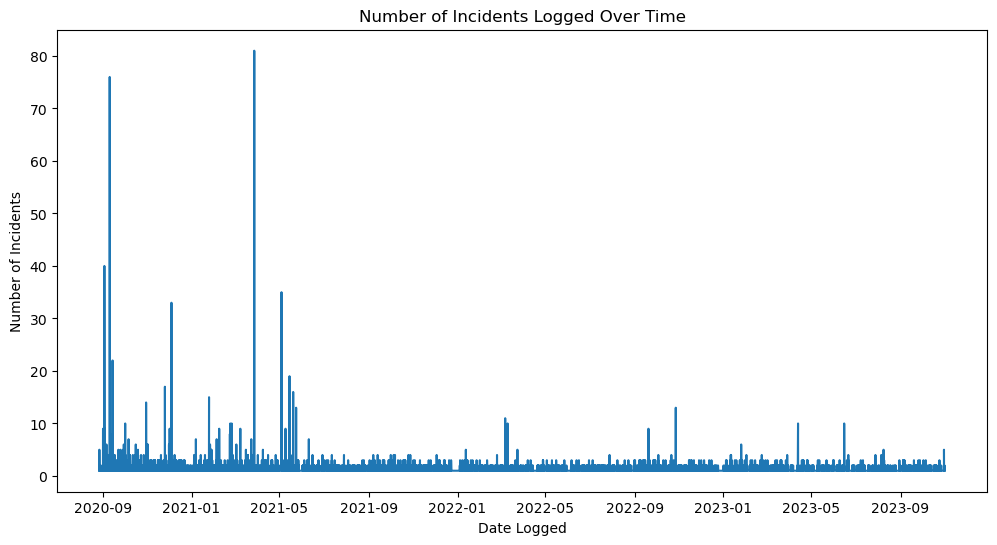

In [387]:
# Plot Time Series analysis of incidents over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='date_logged', y='IncidentID', data=SHUdata, estimator='count', errorbar=None)
plt.title('Number of Incidents Logged Over Time')
plt.xlabel('Date Logged')
plt.ylabel('Number of Incidents')
plt.show()

  date_logged  IncidentID
0  2020-08-31         129
1  2021-02-28       21406
2  2021-08-31       11890
3  2022-02-28       12537
4  2022-08-31        8749
5  2023-02-28       12184
6  2023-08-31        7137


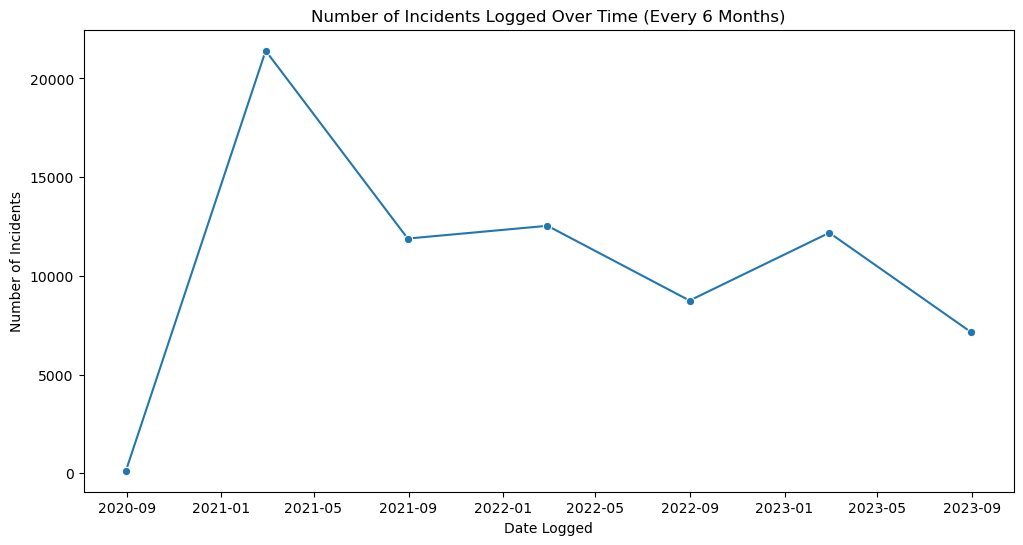

In [388]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'SHUdata' is your DataFrame containing incident data
# Replace 'date_logged', 'IncidentID', and other column names accordingly

# Convert 'date_logged' to datetime if not already in datetime format
SHUdata['date_logged'] = pd.to_datetime(SHUdata['date_logged'])

# Set the end date for the time series analysis (August 31, 2023)
end_date = pd.to_datetime('2023-08-31')

# Filter data to include only entries until the end date
SHUdata_filtered = SHUdata[SHUdata['date_logged'] <= end_date]

# Perform time series analysis with 6-month intervals
time_series_analysis = SHUdata_filtered.groupby(pd.Grouper(key='date_logged', freq='6M'))['IncidentID'].count().reset_index()

# Display the tabularized data
print(time_series_analysis)

# Plot the time series analysis
plt.figure(figsize=(12, 6))
sns.lineplot(x='date_logged', y='IncidentID', data=time_series_analysis, marker='o')
plt.title('Number of Incidents Logged Over Time (Every 6 Months)')
plt.xlabel('Date Logged')
plt.ylabel('Number of Incidents')
plt.show()



   date_logged  IncidentID
0   2020-08-31         129
1   2020-09-30        5929
2   2020-10-31        4417
3   2020-11-30        3256
4   2020-12-31        2454
5   2021-01-31        3040
6   2021-02-28        2310
7   2021-03-31        2389
8   2021-04-30        1939
9   2021-05-31        1875
10  2021-06-30        1850
11  2021-07-31        1759
12  2021-08-31        2078
13  2021-09-30        3068
14  2021-10-31        2614
15  2021-11-30        2025
16  2021-12-31        1324
17  2022-01-31        2059
18  2022-02-28        1447
19  2022-03-31        1699
20  2022-04-30        1224
21  2022-05-31        1518
22  2022-06-30        1349
23  2022-07-31        1442
24  2022-08-31        1517
25  2022-09-30        2783
26  2022-10-31        2380
27  2022-11-30        1980
28  2022-12-31        1299
29  2023-01-31        2288
30  2023-02-28        1454
31  2023-03-31        1536
32  2023-04-30        1258
33  2023-05-31        1127
34  2023-06-30        1200
35  2023-07-31         940
3

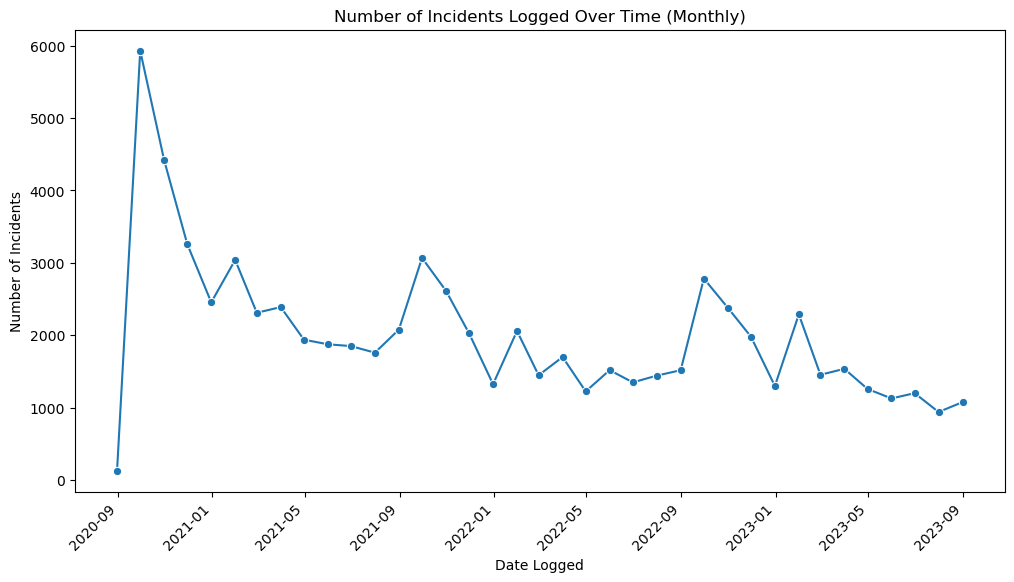

In [389]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'SHUdata' is your DataFrame containing incident data
# Replace 'date_logged', 'IncidentID', and other column names accordingly

# Convert 'date_logged' to datetime if not already in datetime format
SHUdata['date_logged'] = pd.to_datetime(SHUdata['date_logged'])

# Set the end date for the time series analysis (August 31, 2023)
end_date = pd.to_datetime('2023-08-31')

# Filter data to include only entries until the end date
SHUdata_filtered = SHUdata[SHUdata['date_logged'] <= end_date]

# Perform time series analysis with monthly intervals
time_series_analysis = SHUdata_filtered.groupby(pd.Grouper(key='date_logged', freq='M'))['IncidentID'].count().reset_index()

# Display the tabularized data
print(time_series_analysis)

# Plot the time series analysis
plt.figure(figsize=(12, 6))
sns.lineplot(x='date_logged', y='IncidentID', data=time_series_analysis, marker='o')
plt.title('Number of Incidents Logged Over Time (Monthly)')
plt.xlabel('Date Logged')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()


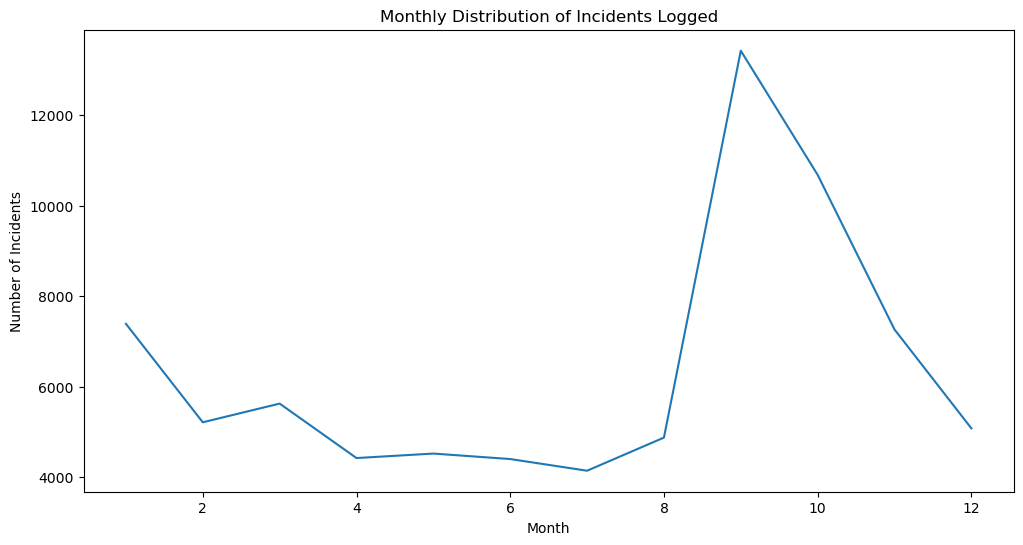

In [390]:
SHUdata['month'] = SHUdata['date_logged'].dt.month
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='IncidentID', data=SHUdata, estimator='count', errorbar=None)
plt.title('Monthly Distribution of Incidents Logged')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.show()

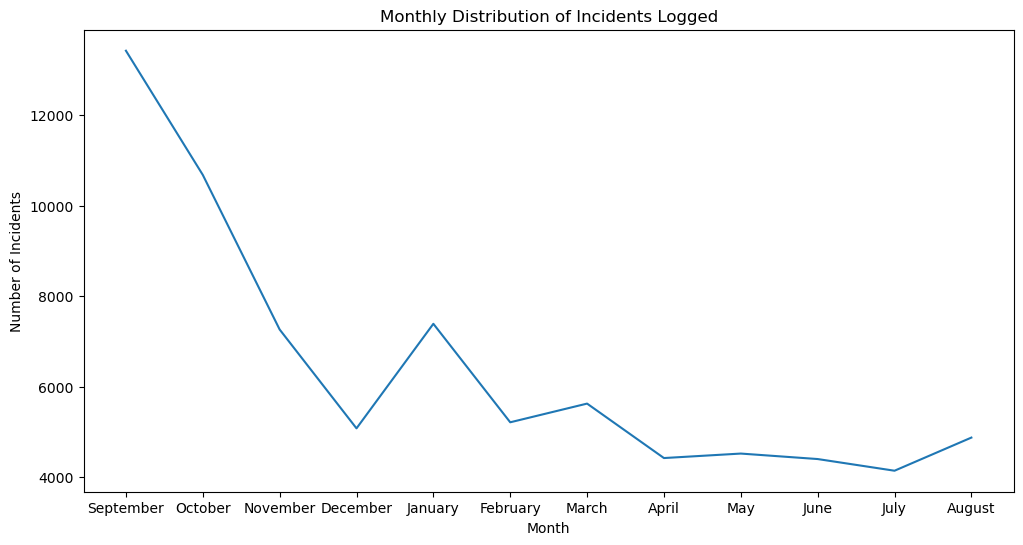

In [391]:
import calendar

# Add a new column 'month_name' to map numeric month values to month names
SHUdata['month_name'] = SHUdata['date_logged'].dt.month.map(lambda x: calendar.month_name[x])

# Plot the monthly distribution with named months
plt.figure(figsize=(12, 6))
sns.lineplot(x='month_name', y='IncidentID', data=SHUdata, estimator='count', errorbar=None)
plt.title('Monthly Distribution of Incidents Logged')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.show()


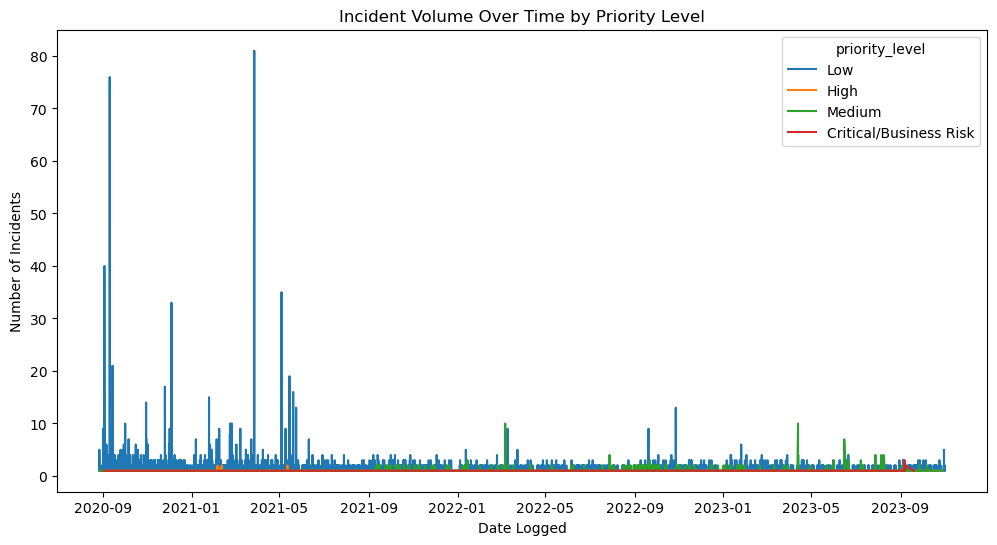

In [392]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='date_logged', y='IncidentID', hue='priority_level', data=SHUdata, estimator='count', errorbar=None)
plt.title('Incident Volume Over Time by Priority Level')
plt.xlabel('Date Logged')
plt.ylabel('Number of Incidents')
plt.show()

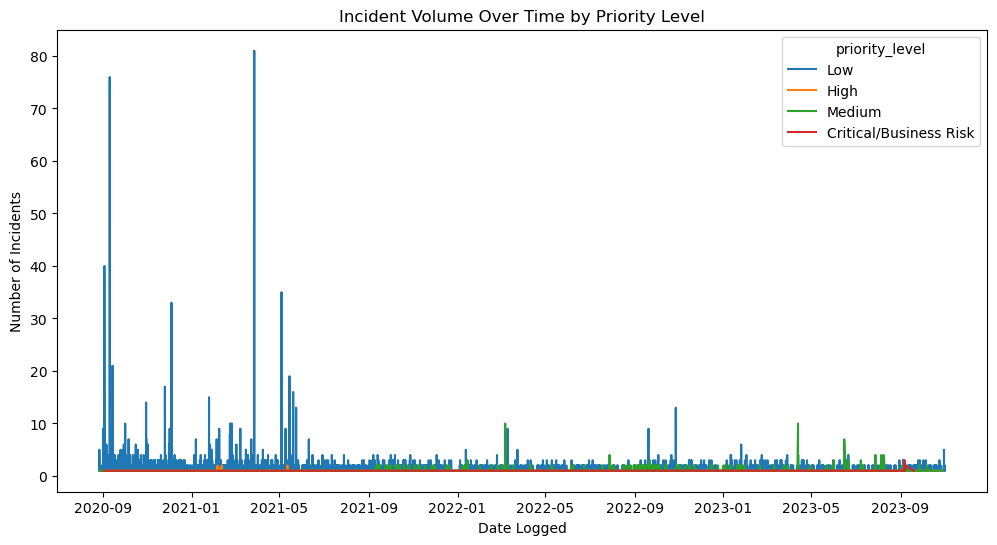

In [393]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='date_logged', y='IncidentID', hue='priority_level', data=SHUdata, estimator='count', errorbar=None)
plt.title('Incident Volume Over Time by Priority Level')
plt.xlabel('Date Logged')
plt.ylabel('Number of Incidents')
plt.show()

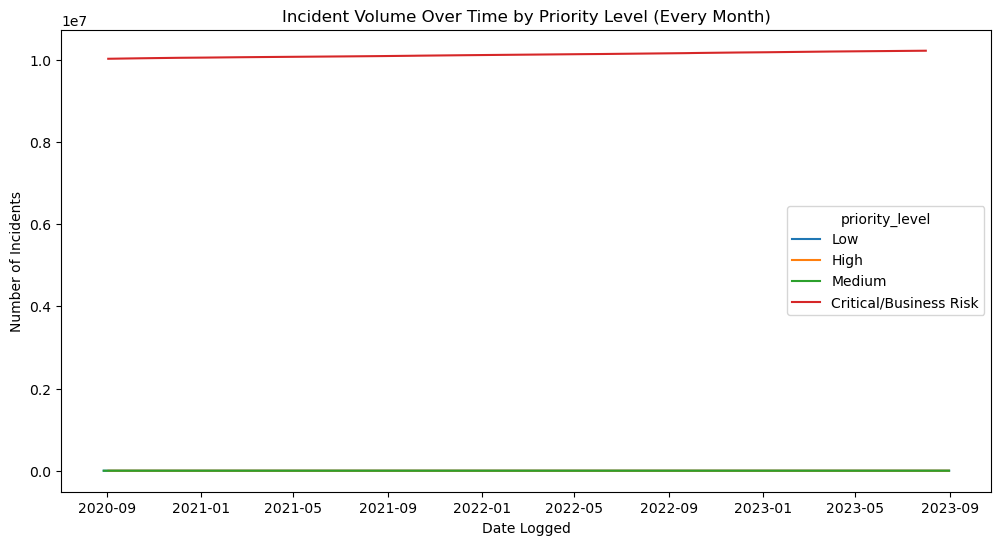

In [394]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Replace 'date_logged', 'IncidentID', 'priority_level', and other column names accordingly

# Convert 'date_logged' to datetime if not already in datetime format
SHUdata['date_logged'] = pd.to_datetime(SHUdata['date_logged'])

# Set the end date for the time series analysis (August 31, 2023)
end_date = pd.to_datetime('2023-08-31')

# Filter data to include only entries until the end date
SHUdata_filtered = SHUdata[SHUdata['date_logged'] <= end_date]

# Plot incident volume by priority level over time every month
plt.figure(figsize=(12, 6))
sns.lineplot(x='date_logged', y='IncidentID', hue='priority_level', data=SHUdata_filtered, estimator='count', errorbar=None)
plt.title('Incident Volume Over Time by Priority Level (Every Month)')
plt.xlabel('Date Logged')
plt.ylabel('Number of Incidents')
plt.show()


In [395]:
# Calculate the difference in days and create a new column 'days_to_resolve'
SHUdata['days_to_resolve'] = (SHUdata['actual_resolution_date'] - SHUdata['date_logged']).dt.days

# Display the updated DataFrame with the new column
SHUdata.head()

,date_logged,incident_category,incident_cause_category,logging_major_category,priority_level,actual_resolution_date,proposed_resolution_date,IncidentID,item_name,product_category,product_name,SLA (hrs),SLA (days),month,month_name,days_to_resolve
0,2020-09-01 11:42:00,To be Qualified,SR_Completed,Incident,Low,2020-09-18 05:30:00,2020-10-05 09:20:00,10024315,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0,9,September,16
1,2020-09-01 11:45:00,To be Qualified,SR_Completed,Incident,Low,2020-09-18 05:30:00,2020-10-05 11:04:00,10024324,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0,9,September,16
2,2020-09-01 11:45:00,To be Qualified,SR_Completed,Incident,Low,2020-09-26 05:30:00,2020-10-09 12:50:00,10024326,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0,9,September,24
3,2020-09-01 12:24:00,To be Qualified,SR_Completed,Incident,Low,2020-09-19 05:30:00,2020-10-05 10:12:00,10024367,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0,9,September,17
4,2020-09-01 12:48:00,To be Qualified,SR_Completed,Incident,Low,2020-09-20 05:30:00,2020-10-02 09:52:00,10024466,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0,9,September,18


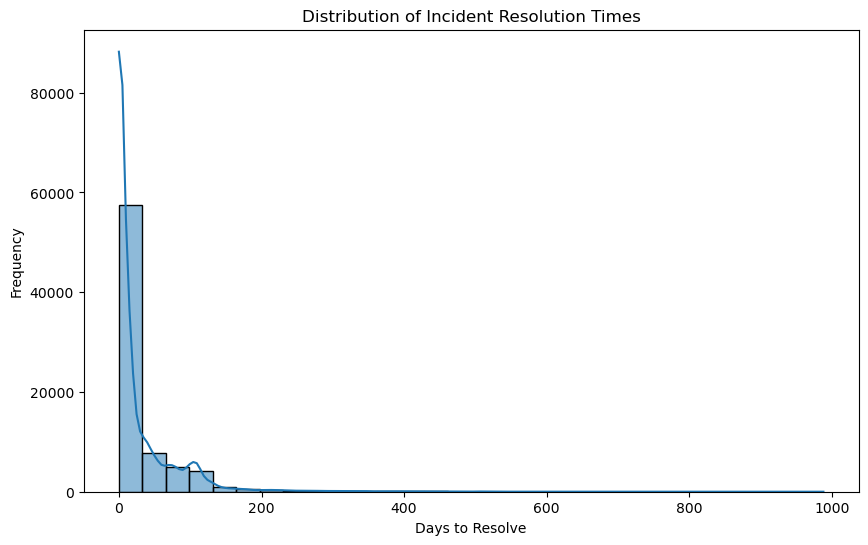

In [396]:
# Distribution of Resolution Times
plt.figure(figsize=(10, 6))
sns.histplot(SHUdata['days_to_resolve'].dropna(), bins=30, kde=True)
plt.title('Distribution of Incident Resolution Times')
plt.xlabel('Days to Resolve')
plt.ylabel('Frequency')
plt.show()

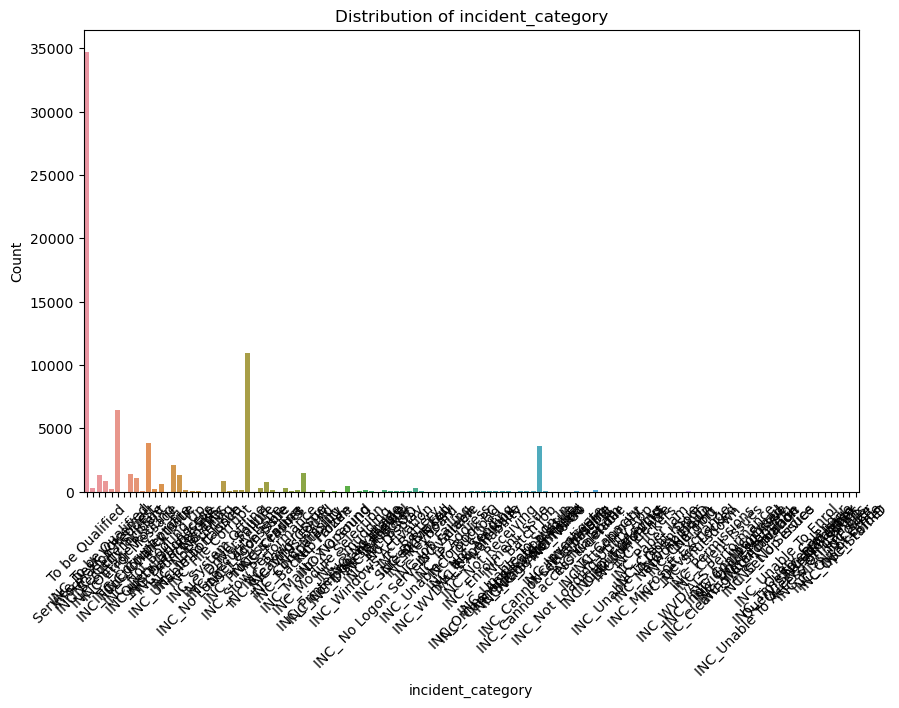

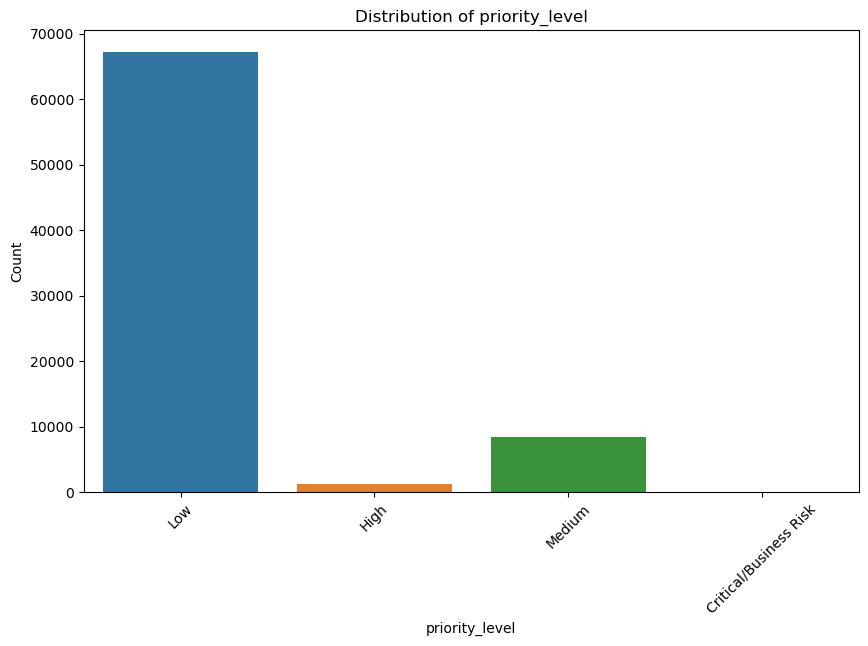

In [397]:
# Categorical Variables: Distribution
categorical_columns = ['incident_category', 'priority_level']
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, data=SHUdata)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

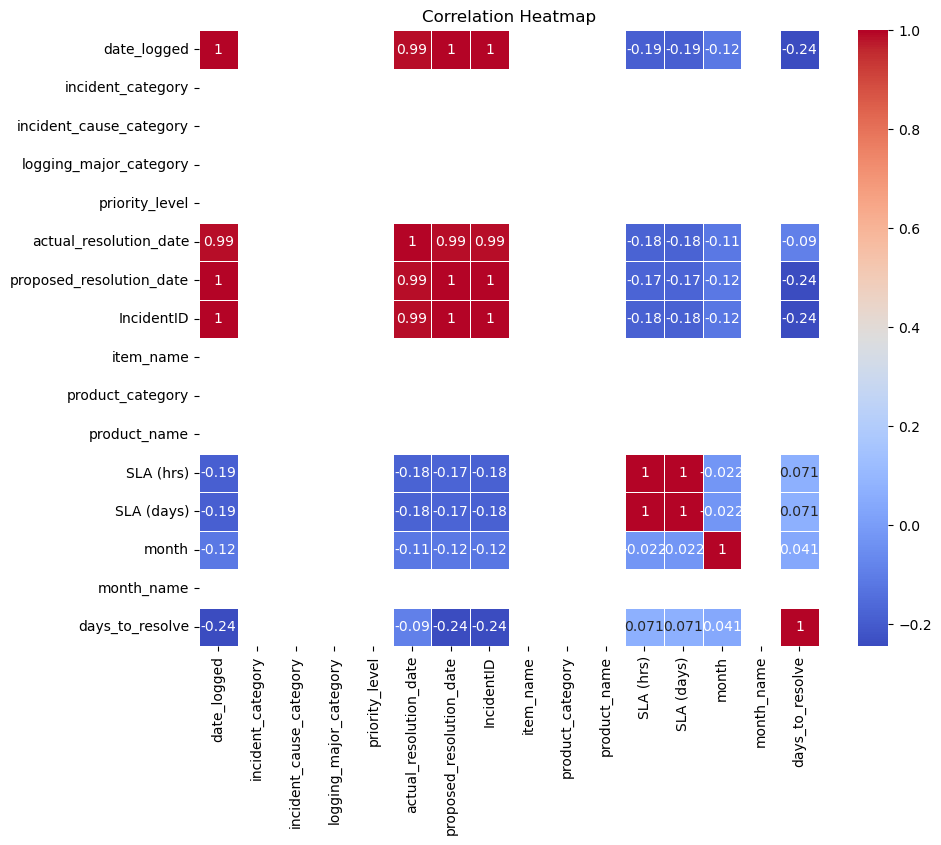

In [398]:
# Convert non-numeric values to NaN
SHUdata_numeric = SHUdata.apply(pd.to_numeric, errors='coerce')

# Calculate the correlation matrix
correlation_matrix = SHUdata_numeric.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [399]:
# Display the correlation matrix as a table
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Display a table of pairwise correlations with a threshold (e.g., 0.5)
correlation_threshold = 0.5
high_correlations = (correlation_matrix[abs(correlation_matrix) > correlation_threshold]
                     .stack()
                     .reset_index()
                     .rename(columns={0: 'Correlation'}))
high_correlations = high_correlations[high_correlations['level_0'] != high_correlations['level_1']]  # Exclude self-correlations
print(f"\nHigh Correlations (Threshold: {correlation_threshold}):")
print(high_correlations)


Correlation Matrix:
                          date_logged  incident_category  \
date_logged                  1.000000                NaN   
incident_category                 NaN                NaN   
incident_cause_category           NaN                NaN   
logging_major_category            NaN                NaN   
priority_level                    NaN                NaN   
actual_resolution_date       0.987794                NaN   
proposed_resolution_date     0.999656                NaN   
IncidentID                   0.999455                NaN   
item_name                         NaN                NaN   
product_category                  NaN                NaN   
product_name                      NaN                NaN   
SLA (hrs)                   -0.187165                NaN   
SLA (days)                  -0.187124                NaN   
month                       -0.116739                NaN   
month_name                        NaN                NaN   
days_to_resolve    

In [400]:
from scipy.stats import chi2_contingency

# Assuming 'data' is your DataFrame containing categorical variables
# Replace 'variable1' and 'variable2' with the actual column names
contingency_table = pd.crosstab(SHUdata['incident_category'], SHUdata['priority_level'])

# Display the contingency table
print("\nContingency Table:")
print(contingency_table)

# Perform the chi-squared test
chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

# Display the chi-squared statistic and p-value
print(f"\nChi-squared Statistic: {chi2_stat}")
print(f"P-value: {p_value}")



Contingency Table:
priority_level                   Critical/Business Risk  High    Low  Medium
incident_category                                                           
INC_ Cannot Se Std Module                             0     0     36       0
INC_ No Logon Servers Available                       0     6     45       1
INC_Activation                                        0     0      4       0
INC_Apple ID                                          0     1      9       0
INC_Attachment                                        0     0      2       0
...                                                 ...   ...    ...     ...
Query_D/L Access                                      0     0      1       0
Query_Permissions                                     0     0      2       0
Query_Shared Mailbox                                  0     0      1       0
Service Desk Voicemail                                0     0    305       0
To be Qualified                                      12 

In [401]:
from scipy.stats import chi2

# Assuming chi_square_statistic is your chi-square test statistic
chi_square_statistic = 10.0  # Replace with your actual test statistic

# Degrees of freedom
degrees_of_freedom = 1  # Replace with the appropriate degrees of freedom

# Calculate p-value using the chi2.sf function
p_value = chi2.sf(chi_square_statistic, degrees_of_freedom)

# Display the calculated p-value
print(f"\nCalculated P-value: {p_value}")



Calculated P-value: 0.001565402258002549


In [402]:
#def chi2_calc(SHUdata,target):
 #   scores=[]
  #  for col in SHUdata.columns:
   #     ct=pd.crosstab(df[col],target)
    #    stat,p,dof,expected=chi2_contingency(ct)
     #   scores.append(p)
    #return pd.DataFrame(scores, index=df.columns, columns=['P value']).sort_values(by='P value')
#chi2_calc(SHUdata[SHUdata.columns.difference(['incident_category', 'priority_level''])]#,SHUdata['Class/ASD'])
#The chi2 score list shows that the last four features have a p-value over 0.05, so the relation between these features and the target is not significant. therefore, it's better if we drop these four.


In [403]:
#Creating a heatmap of the correlations between the numeric columns of the 'SHUdata' DataFrame
#plt.figure(figsize=(18,8))

#training_SHUdata = SHUdata.corr()

#mask = np.triu(np.ones_like(training_SHUdata))
#plt.title('Incident Response Time', y=1.05, size=15)
#sns.heatmap(training_SHUdata, annot=True, cbar=False, mask=mask)
#plt.show()
#print(SHUdata.shape)


In [404]:
#Feature Engineering Process
#Using Chi2 to check for dependence between categorical variables to select features using resulting pvalue
#def chi2_calc(SHUdata,target):
 #   scores=[]
  #  for col in SHUdata.columns:
   #     ct=pd.crosstab(SHUdata[col],target)
    #    stat,p,dof,expected=chi2_contingency(ct)
     #   scores.append(p)
    #return pd.DataFrame(scores, index=SHUdata.columns, columns=['P value']).sort_values(by='P value')
#chi2_calc(SHUdata[SHUdata.columns.difference(['age', 'result'])],SHUdata['Class/ASD'])
#The chi2 score list shows that the last four features have a p-value over 0.05, so the relation between these features and the target is not significant. therefore, it's better if we drop these four.


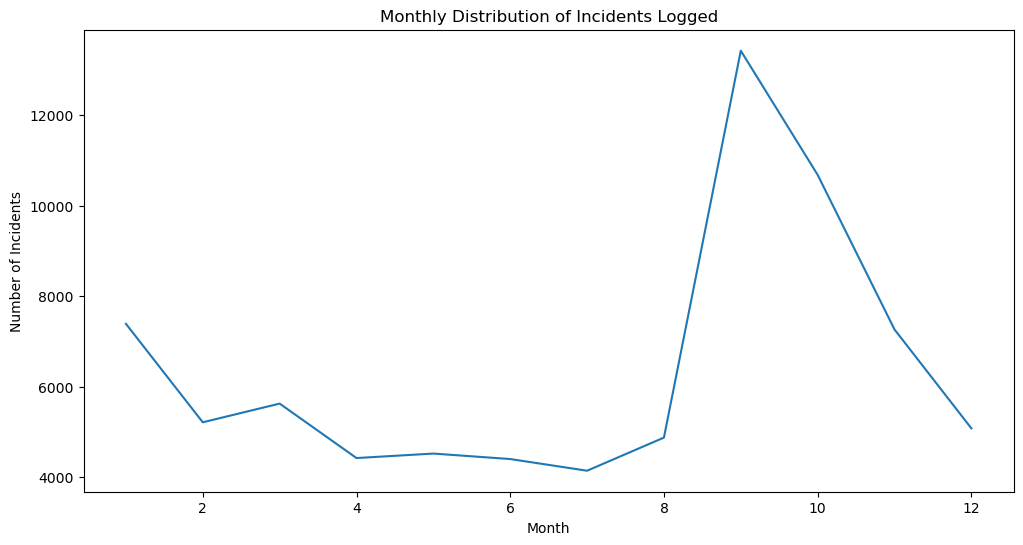

In [405]:
SHUdata['month'] = SHUdata['date_logged'].dt.month
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='IncidentID', data=SHUdata, estimator='count', errorbar=None)
plt.title('Monthly Distribution of Incidents Logged')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.show()

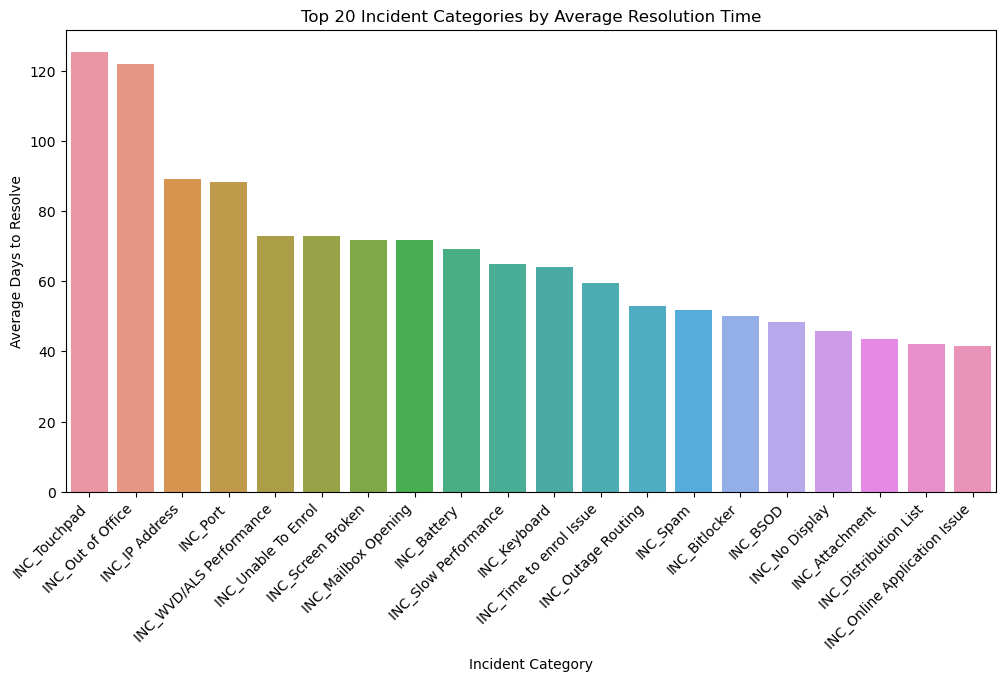

In [406]:
# Calculate average resolution time by incident category
avg_resolution_by_category = SHUdata.groupby('incident_category')['days_to_resolve'].mean().sort_values(ascending=False).head(20)

# Create a bar plot for the top 20 incident categories
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_resolution_by_category.index, y=avg_resolution_by_category.values)
plt.title('Top 20 Incident Categories by Average Resolution Time')
plt.xlabel('Incident Category')
plt.ylabel('Average Days to Resolve')
plt.xticks(rotation=45, ha='right')
plt.show()

In [407]:
SHUdata.shape

(77011, 16)

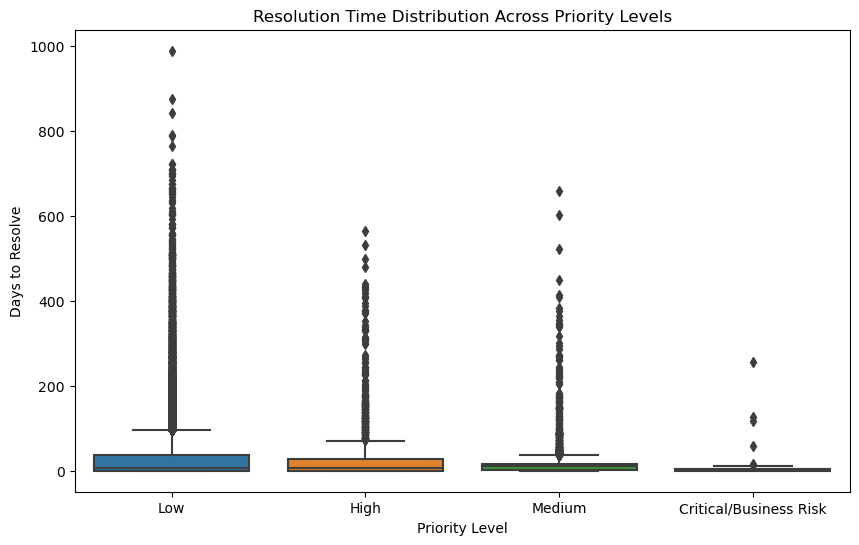


Descriptive Statistics for Resolution Time Across Priority Levels:
                          count       mean        std  min  25%   50%   75%  \
priority_level                                                                
Critical/Business Risk     74.0  10.162162  35.388655  0.0  0.0   3.0   5.0   
High                     1330.0  35.117293  72.903503  0.0  0.0   6.5  28.0   
Low                     67139.0  29.925096  55.129293  0.0  0.0   6.0  38.0   
Medium                   8468.0  15.168871  27.241000  0.0  2.0  12.0  16.0   

                          max  
priority_level                 
Critical/Business Risk  255.0  
High                    563.0  
Low                     988.0  
Medium                  658.0  


In [408]:

plt.figure(figsize=(10, 6))
sns.boxplot(x='priority_level', y='days_to_resolve', data=SHUdata)
plt.title('Resolution Time Distribution Across Priority Levels')
plt.xlabel('Priority Level')
plt.ylabel('Days to Resolve')
plt.show()

# Group by priority level and calculate descriptive statistics
grouped_stats = SHUdata.groupby('priority_level')['days_to_resolve'].describe()

# Display the statistics table
print("\nDescriptive Statistics for Resolution Time Across Priority Levels:")
print(grouped_stats)

In [409]:
# Select rows where resolution time is negative

# Filter rows with negative 'days_to_resolve' and display the top 10
top10_negative_days_rows = SHUdata[SHUdata['days_to_resolve'] < 0].head(10)

# Print the filtered DataFrame
print(top10_negative_days_rows[['IncidentID','date_logged', 'priority_level','actual_resolution_date', 'days_to_resolve', 'proposed_resolution_date',  'SLA (hrs)', 'SLA (days)']])

Empty DataFrame
Columns: [IncidentID, date_logged, priority_level, actual_resolution_date, days_to_resolve, proposed_resolution_date, SLA (hrs), SLA (days)]
Index: []


In [410]:
# Filter rows with negative 'days_to_resolve'
negative_days_rows = SHUdata[SHUdata['days_to_resolve'] < 0]

# write to csv
csv_file_path = 'negative_days_data.csv'

# Write the DataFrame to a CSV file
negative_days_rows.to_csv(csv_file_path, index=False)

# Print a message indicating the file has been saved
print(f"The data with negative 'days_to_resolve' values has been saved to {csv_file_path}.")

The data with negative 'days_to_resolve' values has been saved to negative_days_data.csv.


In [411]:
#rewrite the dataframe to show only filtered rows tht do not have negative days_to_resolve field i.e where resolution date is less than the date logged
SHUdata = SHUdata[SHUdata['days_to_resolve'] >= 0]

In [412]:
SHUdata.shape

(77011, 16)

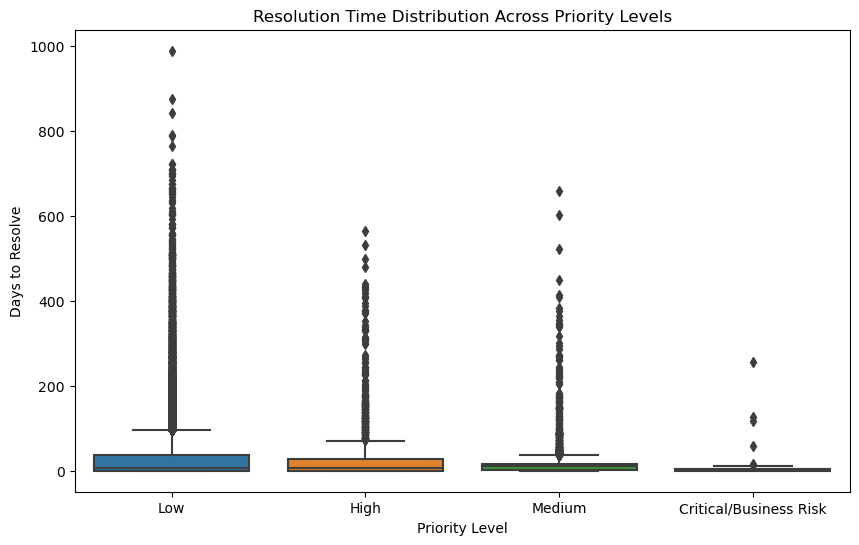


Descriptive Statistics for Resolution Time Across Priority Levels:
                          count       mean        std  min  25%   50%   75%  \
priority_level                                                                
Critical/Business Risk     74.0  10.162162  35.388655  0.0  0.0   3.0   5.0   
High                     1330.0  35.117293  72.903503  0.0  0.0   6.5  28.0   
Low                     67139.0  29.925096  55.129293  0.0  0.0   6.0  38.0   
Medium                   8468.0  15.168871  27.241000  0.0  2.0  12.0  16.0   

                          max  
priority_level                 
Critical/Business Risk  255.0  
High                    563.0  
Low                     988.0  
Medium                  658.0  


In [413]:

plt.figure(figsize=(10, 6))
sns.boxplot(x='priority_level', y='days_to_resolve', data=SHUdata)
plt.title('Resolution Time Distribution Across Priority Levels')
plt.xlabel('Priority Level')
plt.ylabel('Days to Resolve')
plt.show()

# Group by priority level and calculate descriptive statistics
grouped_stats = SHUdata.groupby('priority_level')['days_to_resolve'].describe()

# Display the statistics table
print("\nDescriptive Statistics for Resolution Time Across Priority Levels:")
print(grouped_stats)

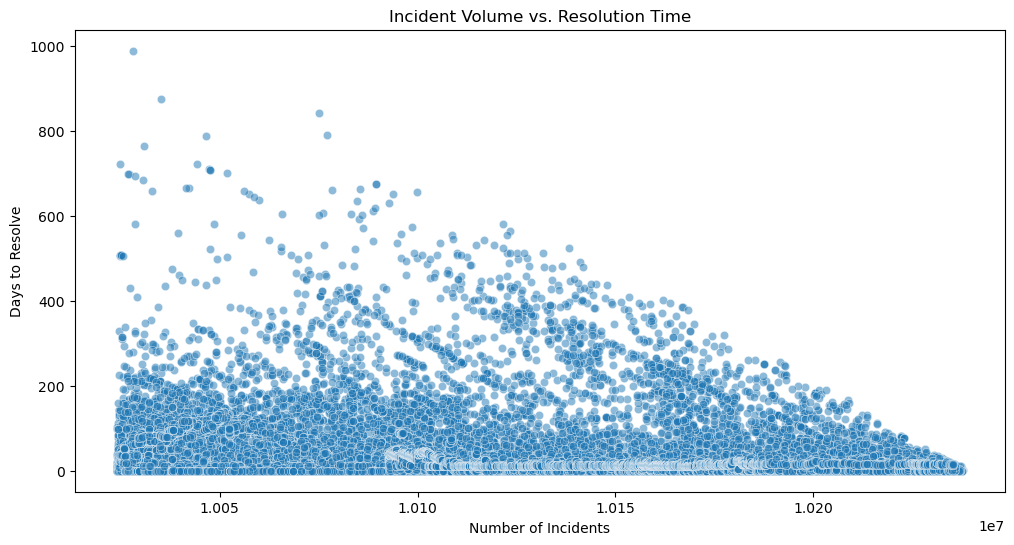


Count of Incidents Against Resolution Time in Days:
     days_to_resolve  IncidentID
0                  0       24892
1                  1        4246
2                  2        2315
3                  3        1774
4                  4        1328
..               ...         ...
526              788           1
527              789           1
528              841           1
529              875           1
530              988           1

[531 rows x 2 columns]


In [414]:
#display scatterplot
plt.figure(figsize=(12, 6))
sns.scatterplot(x='IncidentID', y='days_to_resolve', data=SHUdata, alpha=0.5)
plt.title('Incident Volume vs. Resolution Time')
plt.xlabel('Number of Incidents')
plt.ylabel('Days to Resolve')
plt.show()


# Group by days_to_resolve and count incidents
incident_counts = SHUdata.groupby('days_to_resolve')['IncidentID'].count().reset_index()

# Display the table
print("\nCount of Incidents Against Resolution Time in Days:")
print(incident_counts)

In [415]:
# Main Data Preprocessing
# Set 'date_logged' as the index for time series analysis
#this is to enable time series analysis by setting the datelogged column as the index.
SHUdata.set_index('date_logged', inplace=True)

In [417]:
SHUdata.head(5)

,incident_category,incident_cause_category,logging_major_category,priority_level,actual_resolution_date,proposed_resolution_date,IncidentID,item_name,product_category,product_name,SLA (hrs),SLA (days),month,month_name,days_to_resolve
date_logged,,,,,,,,,,,,,,,
2020-09-01 11:42:00,To be Qualified,SR_Completed,Incident,Low,2020-09-18 05:30:00,2020-10-05 09:20:00,10024315,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0,9,September,16
2020-09-01 11:45:00,To be Qualified,SR_Completed,Incident,Low,2020-09-18 05:30:00,2020-10-05 11:04:00,10024324,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0,9,September,16
2020-09-01 11:45:00,To be Qualified,SR_Completed,Incident,Low,2020-09-26 05:30:00,2020-10-09 12:50:00,10024326,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0,9,September,24
2020-09-01 12:24:00,To be Qualified,SR_Completed,Incident,Low,2020-09-19 05:30:00,2020-10-05 10:12:00,10024367,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0,9,September,17
2020-09-01 12:48:00,To be Qualified,SR_Completed,Incident,Low,2020-09-20 05:30:00,2020-10-02 09:52:00,10024466,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0,9,September,18


In [418]:
# Handle missing values (if any)
# Fill missing values in the target variable (days_to_resolve) with the mean of the column
SHUdata['days_to_resolve'].fillna(SHUdata['days_to_resolve'].mean(), inplace=True)

In [419]:
SHUdata_resampled = SHUdata

In [420]:
SHUdata_resampled.head(5)

,incident_category,incident_cause_category,logging_major_category,priority_level,actual_resolution_date,proposed_resolution_date,IncidentID,item_name,product_category,product_name,SLA (hrs),SLA (days),month,month_name,days_to_resolve
date_logged,,,,,,,,,,,,,,,
2020-09-01 11:42:00,To be Qualified,SR_Completed,Incident,Low,2020-09-18 05:30:00,2020-10-05 09:20:00,10024315,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0,9,September,16
2020-09-01 11:45:00,To be Qualified,SR_Completed,Incident,Low,2020-09-18 05:30:00,2020-10-05 11:04:00,10024324,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0,9,September,16
2020-09-01 11:45:00,To be Qualified,SR_Completed,Incident,Low,2020-09-26 05:30:00,2020-10-09 12:50:00,10024326,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0,9,September,24
2020-09-01 12:24:00,To be Qualified,SR_Completed,Incident,Low,2020-09-19 05:30:00,2020-10-05 10:12:00,10024367,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0,9,September,17
2020-09-01 12:48:00,To be Qualified,SR_Completed,Incident,Low,2020-09-20 05:30:00,2020-10-02 09:52:00,10024466,To Be Qualified,To Be Qualified,To Be Qualified,127.3,15.0,9,September,18


In [421]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to each column
for column in SHUdata_resampled.columns:
    SHUdata_resampled[column] = label_encoder.fit_transform(SHUdata_resampled[column])

print(SHUdata_resampled)

                     incident_category  incident_cause_category  \
date_logged                                                       
2020-09-01 11:42:00                124                       50   
2020-09-01 11:45:00                124                       50   
2020-09-01 11:45:00                124                       50   
2020-09-01 12:24:00                124                       50   
2020-09-01 12:48:00                124                       50   
...                                ...                      ...   
2023-10-18 05:38:00                 54                       50   
2023-10-18 10:48:00                 54                       50   
2023-10-18 11:16:00                 54                       50   
2023-10-18 13:57:00                 54                       50   
2023-10-18 22:06:00                 54                       50   

                     logging_major_category  priority_level  \
date_logged                                                   
20

In [422]:
#SHUdata.set_index('days_to_resolve', inplace=True)
#SHUdata.set_index('date_logged', inplace=True)
#SHUdata_resampled = SHUdata.resample('D').first()

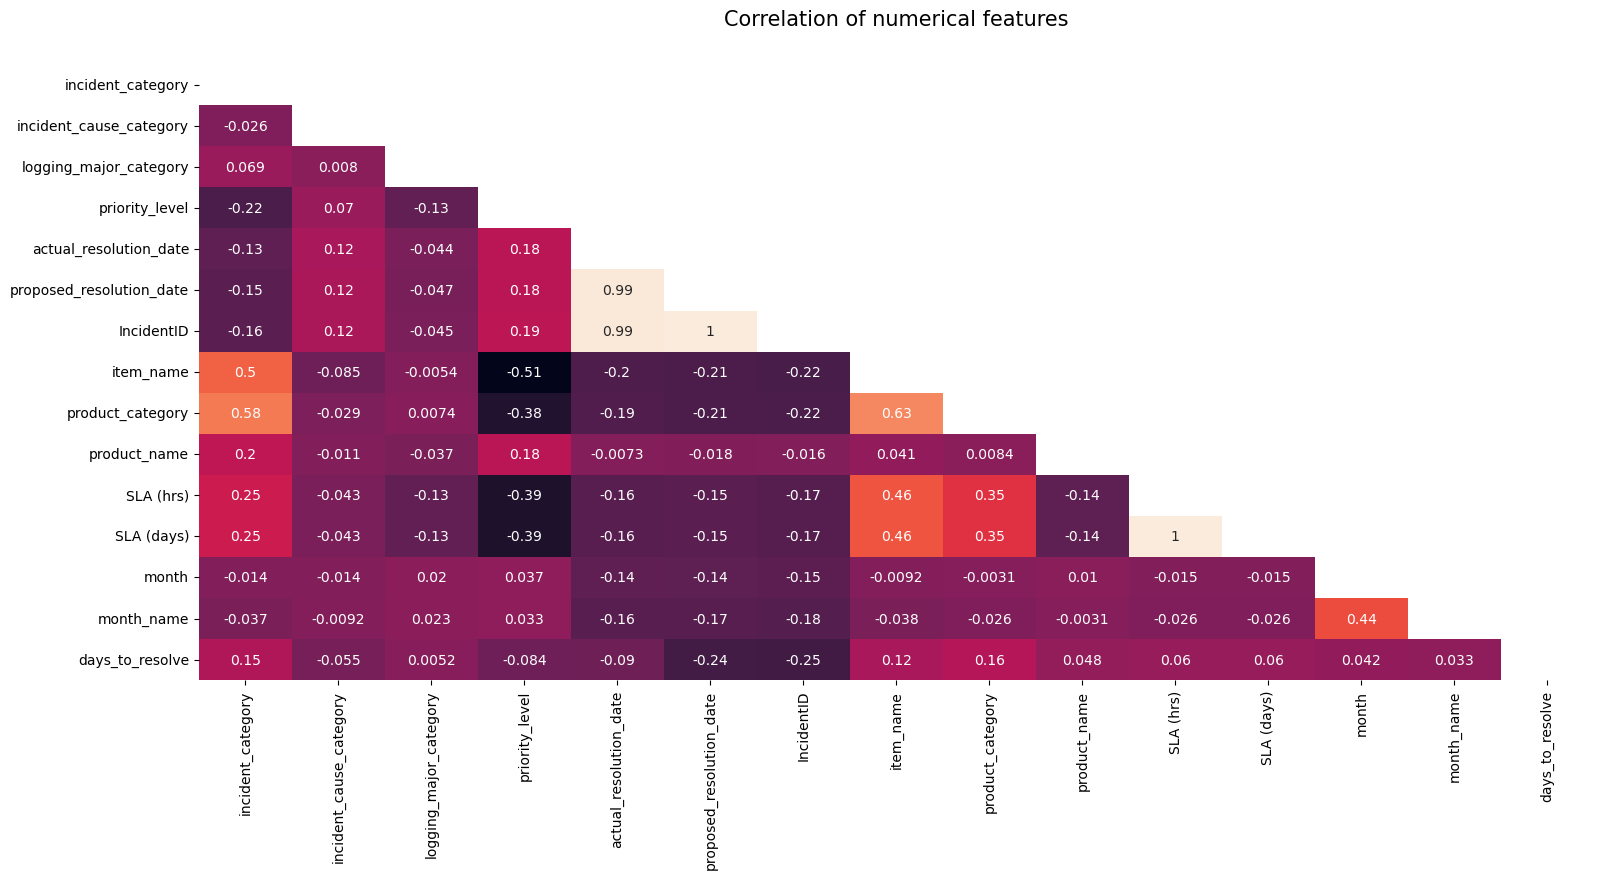

(77011, 15)


In [423]:
#Creating a heatmap of the correlations between the numeric columns of the 'SHUdata' DataFrame
plt.figure(figsize=(18,8))

training_SHUdata = SHUdata.corr()

mask = np.triu(np.ones_like(training_SHUdata))
plt.title('Correlation of numerical features', y=1.05, size=15)
sns.heatmap(training_SHUdata, annot=True, cbar=False, mask=mask)
plt.show()
print(SHUdata.shape)

Correlation Matrix:
                          incident_category  incident_cause_category  \
incident_category                  1.000000                -0.026476   
incident_cause_category           -0.026476                 1.000000   
logging_major_category             0.068676                 0.008025   
priority_level                    -0.215985                 0.069548   
actual_resolution_date            -0.134703                 0.117159   
proposed_resolution_date          -0.154965                 0.124148   
IncidentID                        -0.157494                 0.122295   
item_name                          0.501286                -0.084804   
product_category                   0.579339                -0.028888   
product_name                       0.201988                -0.011134   
SLA (hrs)                          0.245139                -0.043355   
SLA (days)                         0.245139                -0.043355   
month                             -0.014199 

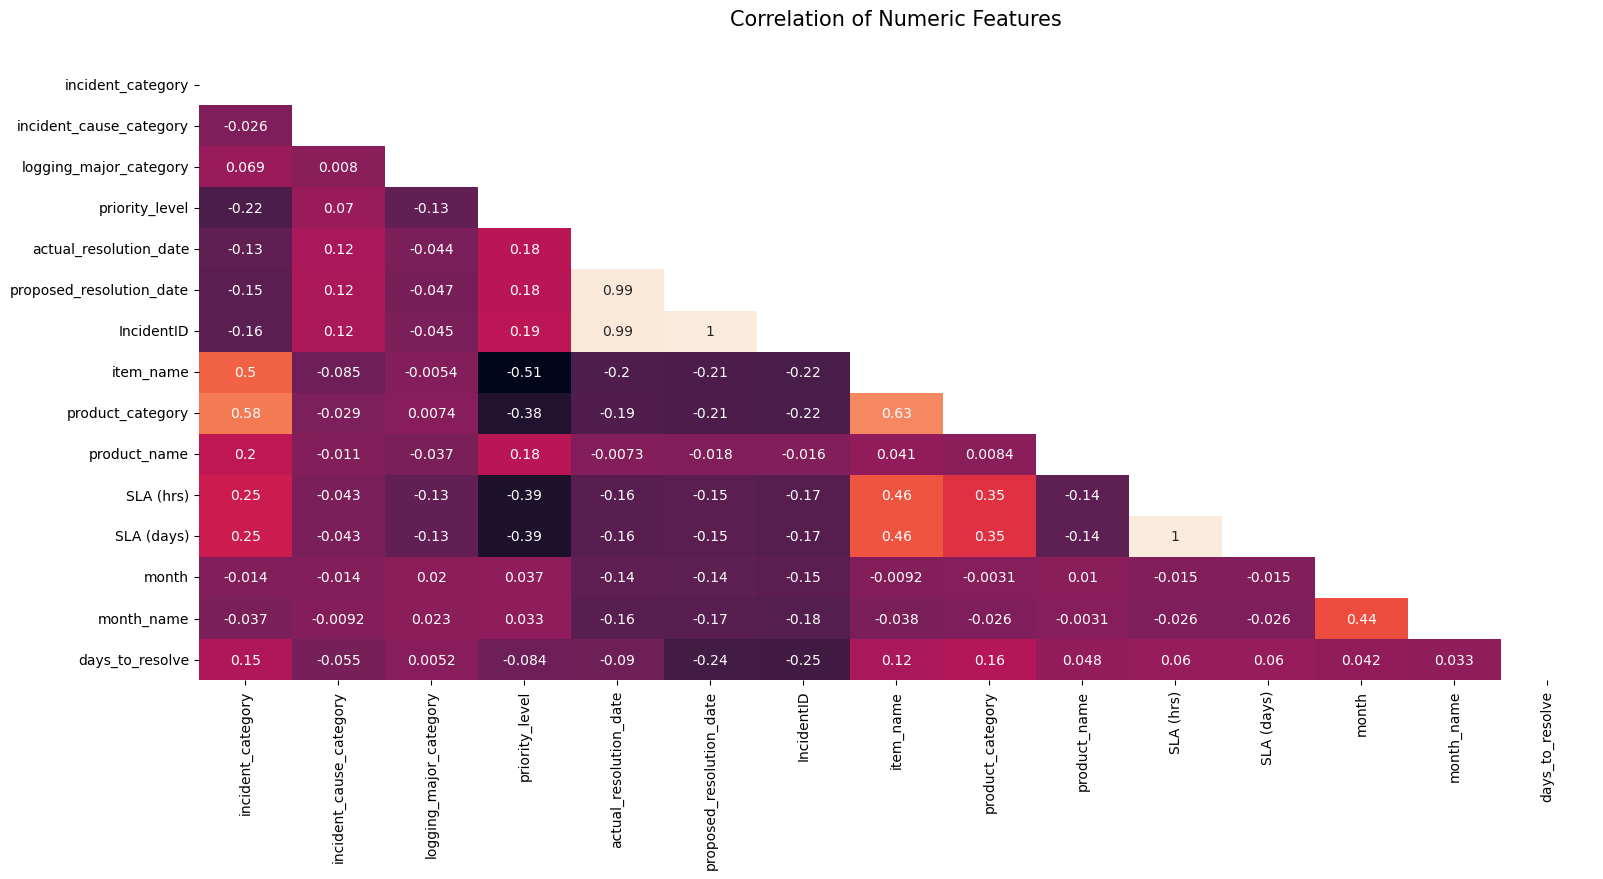

Shape of SHUdata DataFrame: (77011, 15)


In [424]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'SHUdata' is your DataFrame containing numeric columns
# Replace 'SHUdata' and other column names accordingly

# Calculate the correlation matrix
correlation_matrix = SHUdata.corr()

# Display the correlation matrix in tabular form
print("Correlation Matrix:")
print(correlation_matrix)

# Generate a triangular mask to hide the upper triangle for better readability
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(18, 8))

# Create a heatmap with annotations, without color bar, and using the mask
sns.heatmap(correlation_matrix, annot=True, cbar=False, mask=mask)

# Set title and display the plot
plt.title('Correlation of Numeric Features', y=1.05, size=15)
plt.show()

# Print the shape of the original DataFrame
print("Shape of SHUdata DataFrame:", SHUdata.shape)


In [425]:
# Resample the data to daily frequency using mean aggregation (in case the data is not daily)
#SHUdata_resampled = SHUdata.resample('D').mean()

In [426]:
print(len(SHUdata_resampled))
print(len(SHUdata))

77011
77011


In [427]:
SHUdata_resampled.head(5)

,incident_category,incident_cause_category,logging_major_category,priority_level,actual_resolution_date,proposed_resolution_date,IncidentID,item_name,product_category,product_name,SLA (hrs),SLA (days),month,month_name,days_to_resolve
date_logged,,,,,,,,,,,,,,,
2020-09-01 11:42:00,124,50,0,2,1120,1443,148,740,6,46,3,3,8,11,16
2020-09-01 11:45:00,124,50,0,2,1120,1480,157,740,6,46,3,3,8,11,16
2020-09-01 11:45:00,124,50,0,2,1684,2205,159,740,6,46,3,3,8,11,24
2020-09-01 12:24:00,124,50,0,2,1225,1467,199,740,6,46,3,3,8,11,17
2020-09-01 12:48:00,124,50,0,2,1228,1254,297,740,6,46,3,3,8,11,18


In [340]:
# Feature engineering: Create additional features required
# Based on the index (days_to_resolve), time-related features that include are extracted - day of the week, month, and quarter
SHUdata_resampled['day_of_week'] = SHUdata_resampled.index.dayofweek
SHUdata_resampled['month'] = SHUdata_resampled.index.month
SHUdata_resampled['quarter'] = SHUdata_resampled.index.quarter

ValueError: Could not interpret value `day_of_week` for parameter `x`

<Figure size 1200x600 with 0 Axes>

In [434]:
# Use Min-Max scaling to scale the target variable ('days_to_resolve') to a range between 0 and 1
scaler = MinMaxScaler()
SHUdata_resampled['days_to_resolve_scaled'] = scaler.fit_transform(SHUdata_resampled[['days_to_resolve']])

# Print the preprocessed DataFrame
SHUdata_resampled.head()

,incident_category,incident_cause_category,logging_major_category,priority_level,actual_resolution_date,proposed_resolution_date,IncidentID,item_name,product_category,product_name,SLA (hrs),SLA (days),month,month_name,days_to_resolve,days_to_resolve_scaled
date_logged,,,,,,,,,,,,,,,,
2020-09-01 11:42:00,124,50,0,2,1120,1443,148,740,6,46,3,3,8,11,16,0.030189
2020-09-01 11:45:00,124,50,0,2,1120,1480,157,740,6,46,3,3,8,11,16,0.030189
2020-09-01 11:45:00,124,50,0,2,1684,2205,159,740,6,46,3,3,8,11,24,0.045283
2020-09-01 12:24:00,124,50,0,2,1225,1467,199,740,6,46,3,3,8,11,17,0.032075
2020-09-01 12:48:00,124,50,0,2,1228,1254,297,740,6,46,3,3,8,11,18,0.033962


C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self

Actual Values
date_logged
2023-01-19 09:05:00    0.026415
2023-03-17 12:34:00    0.033962
2023-03-22 15:55:00    0.030189
2023-03-29 13:21:00    0.035849
2023-04-03 12:26:00    0.032075
                         ...   
2023-10-18 05:38:00    0.026415
2023-10-18 10:48:00    0.026415
2023-10-18 11:16:00    0.028302
2023-10-18 13:57:00    0.026415
2023-10-18 22:06:00    0.028302
Name: days_to_resolve_scaled, Length: 15403, dtype: float64

Predicted Values
date_logged
2023-01-19 09:05:00    0.021599
2023-03-17 12:34:00    0.024305
2023-03-22 15:55:00    0.022298
2023-03-29 13:21:00    0.022034
2023-04-03 12:26:00    0.021319
                         ...   
2023-10-18 05:38:00    0.030235
2023-10-18 10:48:00    0.030235
2023-10-18 11:16:00    0.030235
2023-10-18 13:57:00    0.030235
2023-10-18 22:06:00    0.030235
Name: predicted_mean, Length: 15403, dtype: float64


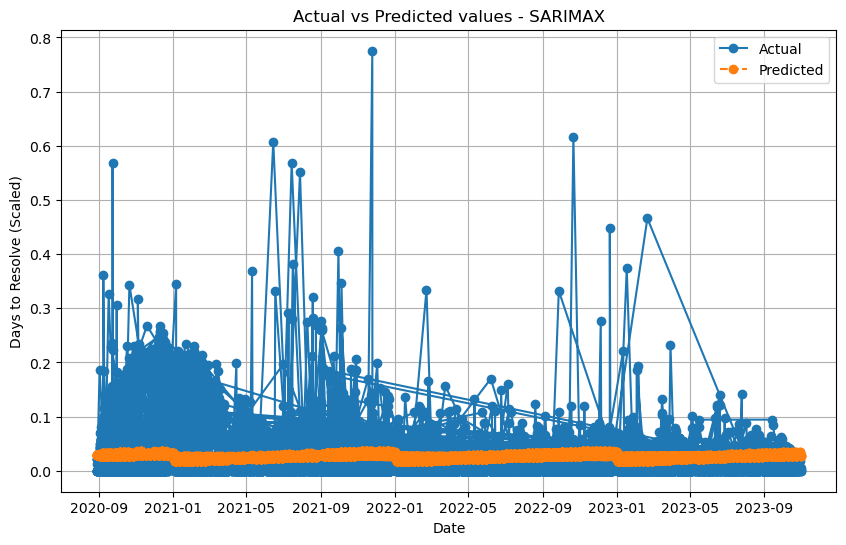

SARIMAX Model - MSE: 0.0021829642972466183, RMSE: 0.046722203471653796 MAE: 0.028092155260369674


In [342]:
# Function to split data into train and test sets
def train_test_split_data(data, test_size=0.2):
    split_index = int(len(data) * (1 - test_size))
    train_data, test_data = data[:split_index], data[split_index:]
    return train_data, test_data

# Function to calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE)
def calculate_errors(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    return mse,rmse, mae

# Function to plot actual vs predicted values
def plot_actual_vs_predicted(actual, predicted, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(actual.index, actual, label='Actual', marker='o')
    plt.plot(actual.index, predicted, label='Predicted', linestyle='dashed', marker='o')
    plt.title(f'Actual vs Predicted values - {model_name}')
    plt.xlabel('Date')
    plt.ylabel('Days to Resolve (Scaled)')
    plt.legend()
    plt.grid(True)
    plt.show()


# SARIMAX Model
def sarimax_model(train, test):
    exog_train = train[['day_of_week', 'month', 'quarter']]
    exog_test = test[['day_of_week', 'month', 'quarter']]

    model = SARIMAX(train['days_to_resolve_scaled'], order=(4, 1, 2), seasonal_order=(4, 0, 3, 12), exog=exog_train)
    sarimax_model = model.fit()

    # Predictions
    sarimax_predictions = sarimax_model.get_forecast(steps=len(test), exog=exog_test).predicted_mean
    sarimax_predictions.index = test.index
    print("Actual Values")
    print(test['days_to_resolve_scaled'])
    print("\nPredicted Values")
    print(sarimax_predictions)

    # Calculate errors
    mse,rmse, mae = calculate_errors(test['days_to_resolve_scaled'], sarimax_predictions)

    # Plot actual vs predicted
    plot_actual_vs_predicted(test['days_to_resolve_scaled'], sarimax_predictions, 'SARIMAX')

    return mse, rmse, mae

# Split data into train and test sets
train_data, test_data = train_test_split_data(SHUdata_resampled, test_size=0.2)

# SARIMAX Model
sarimax_mse, sarimax_rmse, sarimax_mae = sarimax_model(train_data, test_data)
print(f'SARIMAX Model - MSE: {sarimax_mse}, RMSE: {sarimax_rmse} MAE: {sarimax_mae}')


In [348]:
# Function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(actual, predicted):
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mape

# Function to tabulate performance evaluation
def tabulate_performance(models, metrics):
    table_data = {'Model': [], 'MSE': [], 'RMSE': [], 'MAE': [], 'MAPE': []}
    
    for model_name, metric_values in models.items():
        table_data['Model'].append(model_name)
        table_data['MSE'].append(metric_values['MSE'])
        table_data['RMSE'].append(metric_values['RMSE'])
        table_data['MAE'].append(metric_values['MAE'])
        table_data['MAPE'].append(metric_values['MAPE'])
    
    df = pd.DataFrame(table_data)
    print(df)
    
# ARIMA Model
def arima_model(train, test):
    model = ARIMA(train['days_to_resolve_scaled'], order=(5, 1, 0))
    arima_model = model.fit()

    # Predictions
    arima_predictions = arima_model.forecast(steps=len(test))

    # Calculate errors
    mse, rmse, mae = calculate_errors(test['days_to_resolve_scaled'], arima_predictions)
    mape = calculate_mape(test['days_to_resolve_scaled'], arima_predictions)

    # Plot actual vs predicted
    plot_actual_vs_predicted(test['days_to_resolve_scaled'], arima_predictions, 'ARIMA')

    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

# Split data into train and test sets
train_data, test_data = train_test_split_data(SHUdata_resampled, test_size=0.2)

# ARIMA Model
arima_metrics = arima_model(train_data, test_data)
print(f'ARIMA Model - MSE: {arima_metrics["MSE"]}, RMSE: {arima_metrics["RMSE"]}, MAE: {arima_metrics["MAE"]}, MAPE: {arima_metrics["MAPE"]}')

# Tabulate performance evaluation
tabulate_performance({'ARIMA': arima_metrics}, ['MSE', 'RMSE', 'MAE', 'MAPE'])


C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self

TypeError: '<' not supported between instances of 'int' and 'Timestamp'

C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self

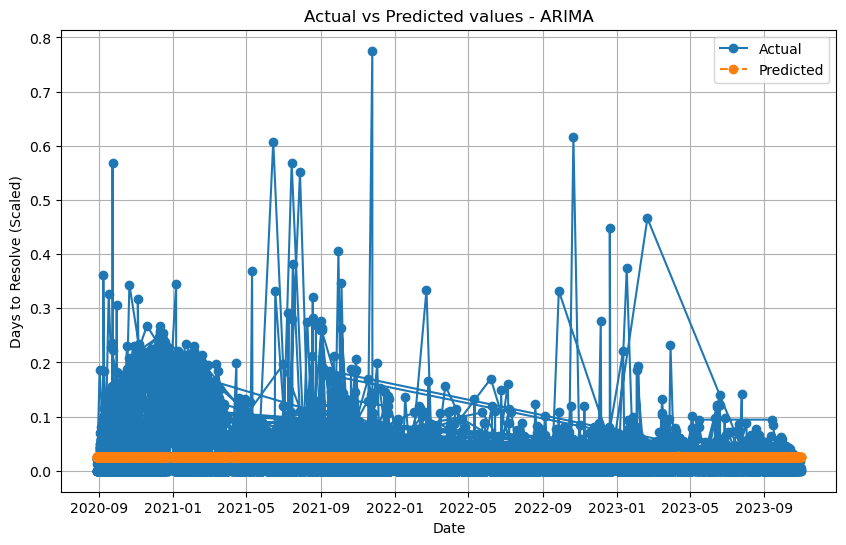

ARIMA Model - MSE: 0.0022186832062659257, RMSE: 0.047102900189541684, MAE: 0.027831529191586546, MAPE: inf


In [435]:
# Function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# ARIMA Model with MAPE calculation
def arima_model_with_mape(train, test):
    model = ARIMA(train['days_to_resolve_scaled'], order=(5, 1, 0))
    arima_model = model.fit()

    # Predictions
    arima_predictions = arima_model.forecast(steps=len(test))

    # Calculate errors
    mse, rmse, mae = calculate_errors(test['days_to_resolve_scaled'], arima_predictions)
    mape = calculate_mape(test['days_to_resolve_scaled'], arima_predictions)

    # Plot actual vs predicted
    plot_actual_vs_predicted(test['days_to_resolve_scaled'], arima_predictions, 'ARIMA')

    return mse, rmse, mae, mape

# ARIMA Model with MAPE
arima_mse, arima_rmse, arima_mae, arima_mape = arima_model_with_mape(train_data, test_data)
print(f'ARIMA Model - MSE: {arima_mse}, RMSE: {arima_rmse}, MAE: {arima_mae}, MAPE: {arima_mape}')


C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self

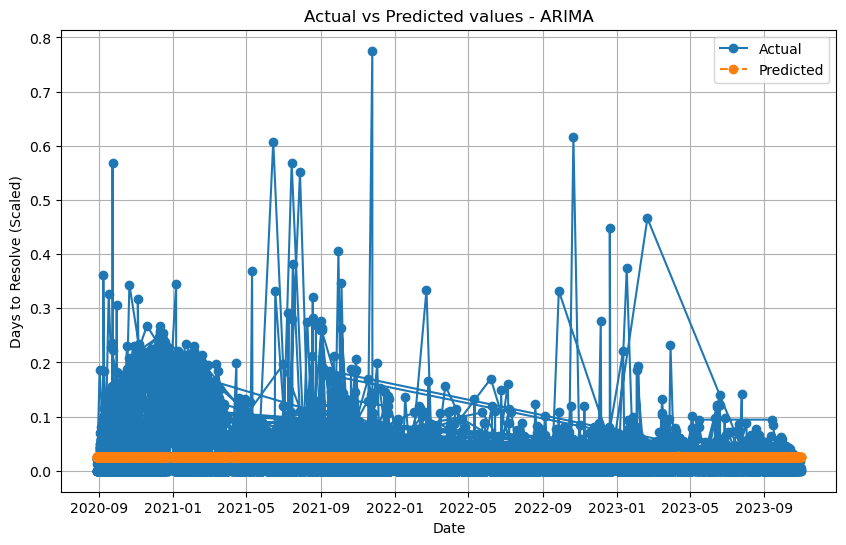

ARIMA Model - MSE: 0.0022186832062659257, RMSE: 0.047102900189541684, MAE: 0.027831529191586546


In [349]:
# Function to split data into train and test sets
def train_test_split_data(data, test_size=0.2):
    split_index = int(len(data) * (1 - test_size))
    train_data, test_data = data[:split_index], data[split_index:]
    return train_data, test_data

# Function to calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE)
def calculate_errors(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    return mse,rmse, mae

# Function to plot actual vs predicted values
def plot_actual_vs_predicted(actual, predicted, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(actual.index, actual, label='Actual', marker='o')
    plt.plot(actual.index, predicted, label='Predicted', linestyle='dashed', marker='o')
    plt.title(f'Actual vs Predicted values - {model_name}')
    plt.xlabel('Date')
    plt.ylabel('Days to Resolve (Scaled)')
    plt.legend()
    plt.grid(True)
    plt.show()

# ARIMA Model
def arima_model(train, test):
    model = ARIMA(train['days_to_resolve_scaled'], order=(5, 1, 0))
    arima_model = model.fit()

    # Predictions
    arima_predictions = arima_model.forecast(steps=len(test))

    # Calculate errors
    mse,rmse, mae = calculate_errors(test['days_to_resolve_scaled'], arima_predictions)

    # Plot actual vs predicted
    plot_actual_vs_predicted(test['days_to_resolve_scaled'], arima_predictions, 'ARIMA')

    return mse, rmse, mae


# Split data into train and test sets
train_data, test_data = train_test_split_data(SHUdata_resampled, test_size=0.2)

# ARIMA Model
arima_mse, arima_rmse, arima_mae = arima_model(train_data, test_data)
print(f'ARIMA Model - MSE: {arima_mse}, RMSE: {arima_rmse}, MAE: {arima_mae}')


C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self

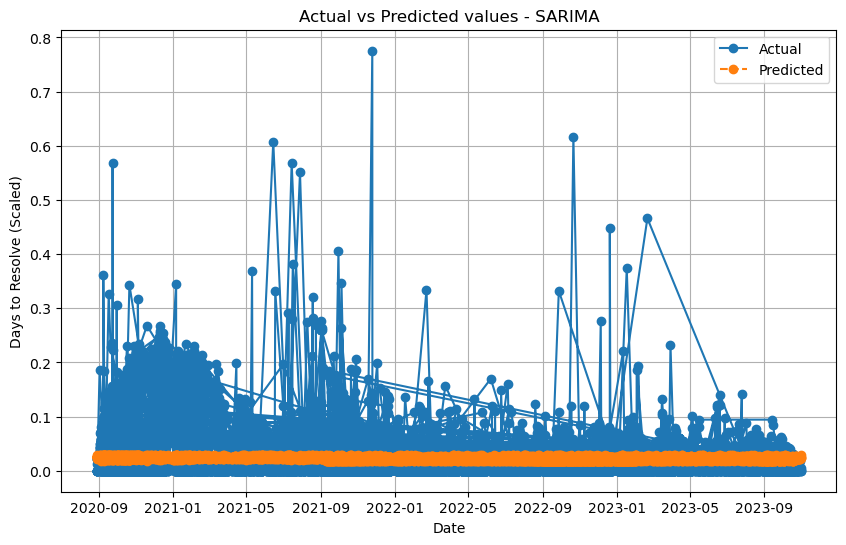

SARIMA Model - MSE: 0.002240864612539748, RMSE: 0.04733777152063401, MAE: 0.027641571607955304


In [356]:
# Function to split data into train and test sets
def train_test_split_data(data, test_size=0.2):
    split_index = int(len(data) * (1 - test_size))
    train_data, test_data = data[:split_index], data[split_index:]
    return train_data, test_data

# Function to calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE)
def calculate_errors(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    return mse,rmse, mae

# Function to plot actual vs predicted values
def plot_actual_vs_predicted(actual, predicted, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(actual.index, actual, label='Actual', marker='o')
    plt.plot(actual.index, predicted, label='Predicted', linestyle='dashed', marker='o')
    plt.title(f'Actual vs Predicted values - {model_name}')
    plt.xlabel('Date')
    plt.ylabel('Days to Resolve (Scaled)')
    plt.legend()
    plt.grid(True)
    plt.show()

    
# SARIMA Model
def sarima_model(train, test):
    model = SARIMAX(train['days_to_resolve_scaled'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_model = model.fit()

    # Predictions
    sarima_predictions = sarima_model.get_forecast(steps=len(test)).predicted_mean

    # Calculate errors
    mse, rmse, mae = calculate_errors(test['days_to_resolve_scaled'], sarima_predictions)

    # Plot actual vs predicted
    plot_actual_vs_predicted(test['days_to_resolve_scaled'], sarima_predictions, 'SARIMA')

    return mse,rmse, mae


# Split data into train and test sets
train_data, test_data = train_test_split_data(SHUdata_resampled, test_size=0.2)


# SARIMA Model
sarima_mse, sarima_rmse, sarima_mae = sarima_model(train_data, test_data)
print(f'SARIMA Model - MSE: {sarima_mse}, RMSE: {sarima_rmse}, MAE: {sarima_mae}')

In [441]:
# Function to split data into train and test sets
def train_test_split_data(data, test_size=0.2):
    split_index = int(len(data) * (1 - test_size))
    train_data, test_data = data[:split_index], data[split_index:]
    return train_data, test_data

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Function to calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE)
def calculate_errors(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    return mse,rmse, mae

def tabulate_results(model_name, mse, rmse, mae, mape):
    table = PrettyTable()
    table.field_names = ["Model", "MSE", "RMSE", "MAE",]
    table.add_row([model_name, mse, rmse, mae, mape])
    print(table)

# Function to plot actual vs predicted values
def plot_actual_vs_predicted(actual, predicted, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(actual.index, actual, label='Actual', marker='o')
    plt.plot(actual.index, predicted, label='Predicted', linestyle='dashed', marker='o')
    plt.title(f'Actual vs Predicted values - {model_name}')
    plt.xlabel('Date')
    plt.ylabel('Days to Resolve (Scaled)')
    plt.legend()
    plt.show()

# LSTM Model
def lstm_model(train, test):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Reshape data for LSTM
    X_train, y_train = np.array(train), np.array(train['days_to_resolve_scaled'])
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    X_test, y_test = np.array(test), np.array(test['days_to_resolve_scaled'])
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Fit the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    # Predictions
    lstm_predictions = model.predict(X_test)

    # Invert scaling for predictions
    lstm_predictions = scaler.inverse_transform(lstm_predictions)

    # Invert scaling for actual values
    actual_values = scaler.inverse_transform(np.array(test['days_to_resolve_scaled']).reshape(-1, 1))

    # Calculate errors
    #mse, rmse, mae, mape = calculate_errors(actual_values, lstm_predictions)
    
    # Evaluate LSTM model
    lstm_mse = mean_squared_error(test['days_to_resolve'], lstm_predictions)
    lstm_rmse = np.sqrt(lstm_mse)
    lstm_mae = mean_absolute_error(test['days_to_resolve'], lstm_predictions)
    lstm_mape = mean_absolute_percentage_error(test['days_to_resolve'], lstm_predictions)

    return lstm_mse, lstm_rmse, lstm_mae, lstm_mape
    

    # Plot actual vs predicted
    plot_actual_vs_predicted(test['days_to_resolve_scaled'], lstm_predictions, 'LSTM')

    #return mse,rmse, mae
# Split data into train and test sets
train_data, test_data = train_test_split_data(SHUdata_resampled, test_size=0.2)

# LSTM Model
lstm_mse, lstm_rmse, lstm_mae = lstm_model(train_data, test_data)
print(f'LSTM Model - MSE: {lstm_mse}, RMSE: {lstm_rmse} MAE: {lstm_mae}, RMSE: {lstm_mape}')


482/482 [==============================] - 1s 3ms/step


C:\Users\SA2404\AppData\Local\Temp\ipykernel_27196\2476840592.py:9: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


ValueError: too many values to unpack (expected 3)

In [442]:
from sklearn.ensemble import RandomForestRegressor

# Separate features and target variable
X = SHUdata_resampled.drop('days_to_resolve_scaled', axis=1)
y = SHUdata_resampled['days_to_resolve_scaled']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Get feature importance scores
feature_importance = rf_model.feature_importances_

# Create a DataFrame to tabulate feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort the DataFrame by Importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the tabulated feature importance
print(feature_importance_df)


                     Feature    Importance
14           days_to_resolve  9.999980e-01
4     actual_resolution_date  2.995840e-07
5   proposed_resolution_date  2.965782e-07
13                month_name  2.179962e-07
1    incident_cause_category  2.084281e-07
6                 IncidentID  1.920220e-07
12                     month  1.744743e-07
9               product_name  1.699647e-07
7                  item_name  1.553886e-07
0          incident_category  1.515540e-07
8           product_category  9.613142e-08
3             priority_level  1.108562e-08
10                 SLA (hrs)  1.055257e-08
11                SLA (days)  1.049639e-08
2     logging_major_category  6.964469e-09


In [443]:
from sklearn.ensemble import RandomForestRegressor

# Separate features and target variable
X = SHUdata_resampled.drop('days_to_resolve_scaled', axis=1)
y = SHUdata_resampled['days_to_resolve_scaled']

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor()

# Fit the model
rf_model.fit(X, y)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to store feature names and their corresponding importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Calculate the percentage importance
feature_importance_df['Importance Percentage'] = (feature_importance_df['Importance'] / feature_importance_df['Importance'].sum()) * 100

# Display the tabulated feature importance
print(feature_importance_df)


                     Feature    Importance  Importance Percentage
14           days_to_resolve  9.999986e-01           9.999986e+01
4     actual_resolution_date  2.623571e-07           2.623571e-05
12                     month  1.600002e-07           1.600002e-05
13                month_name  1.497879e-07           1.497879e-05
5   proposed_resolution_date  1.479279e-07           1.479279e-05
6                 IncidentID  1.411240e-07           1.411240e-05
1    incident_cause_category  1.378011e-07           1.378011e-05
7                  item_name  1.130325e-07           1.130325e-05
9               product_name  1.080258e-07           1.080258e-05
0          incident_category  8.633919e-08           8.633919e-06
8           product_category  8.153032e-08           8.153032e-06
3             priority_level  8.022186e-09           8.022186e-07
11                SLA (days)  5.614094e-09           5.614094e-07
10                 SLA (hrs)  4.618731e-09           4.618731e-07
2     logg

In [362]:
# Function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(actual, predicted):
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mape

# Function to tabulate performance evaluation
def tabulate_performance(models, metrics):
    table_data = {'Model': [], 'MSE': [], 'RMSE': [], 'MAE': [], 'MAPE': []}
    
    for model_name, metric_values in models.items():
        table_data['Model'].append(model_name)
        table_data['MSE'].append(metric_values['MSE'])
        table_data['RMSE'].append(metric_values['RMSE'])
        table_data['MAE'].append(metric_values['MAE'])
        table_data['MAPE'].append(metric_values['MAPE'])
    
    df = pd.DataFrame(table_data)
    print(df)
    
# ARIMA Model
def arima_model(train, test):
    model = ARIMA(train['days_to_resolve_scaled'], order=(5, 1, 0))
    arima_model = model.fit()

    # Predictions
    arima_predictions = arima_model.forecast(steps=len(test))

    # Calculate errors
    mse, rmse, mae = calculate_errors(test['days_to_resolve_scaled'], arima_predictions)
    mape = calculate_mape(test['days_to_resolve_scaled'], arima_predictions)

    # Plot actual vs predicted
    plot_actual_vs_predicted(test['days_to_resolve_scaled'], arima_predictions, 'ARIMA')

    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

# Split data into train and test sets
train_data, test_data = train_test_split_data(SHUdata_resampled, test_size=0.2)

# ARIMA Model
arima_metrics = arima_model(train_data, test_data)
print(f'ARIMA Model - MSE: {arima_metrics["MSE"]}, RMSE: {arima_metrics["RMSE"]}, MAE: {arima_metrics["MAE"]}, MAPE: {arima_metrics["MAPE"]}')

# Tabulate performance evaluation
tabulate_performance({'ARIMA': arima_metrics}, ['MSE', 'RMSE', 'MAE', 'MAPE'])



C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self

TypeError: '<' not supported between instances of 'int' and 'Timestamp'

In [273]:
# Results
#results = {
 #   'Model': ['LSTM'],
  #  'MSE': [lstm_mse],
   # 'RMSE': [lstm_rmse],
    #'MAE': [lstm_mae],
#}

# Create DataFrame
#df_results = pd.DataFrame(results)

# Calculate MAPE (Assuming actual and predicted values are available)
#actual_values = test_data['days_to_resolve_scaled']
#predicted_values = lstm_predictions.flatten()  # Assuming lstm_predictions is a 1D array

#mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
#df_results['MAPE'] = mape

# Display the table
#print(df_results)

482/482 [==============================] - 2s 3ms/step


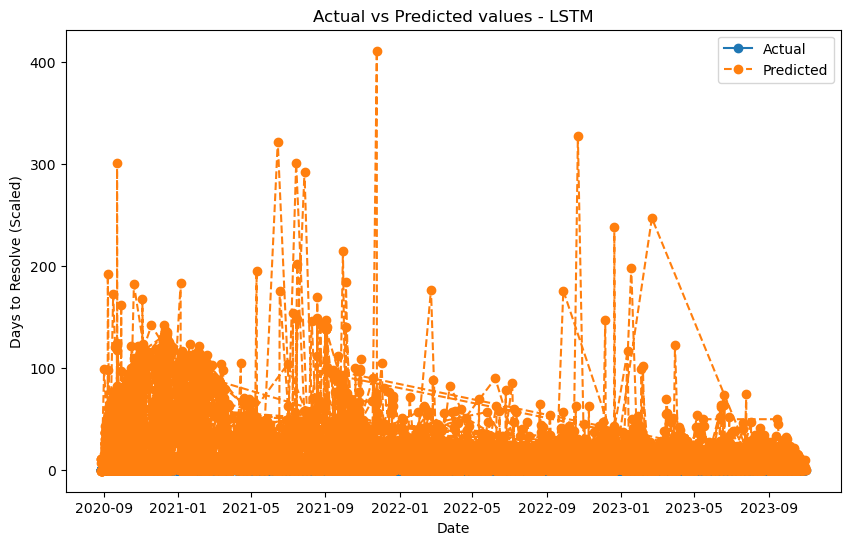

LSTM Model - MSE: 0.0004954514236283436, MAE: 0.015076852146187031


C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self

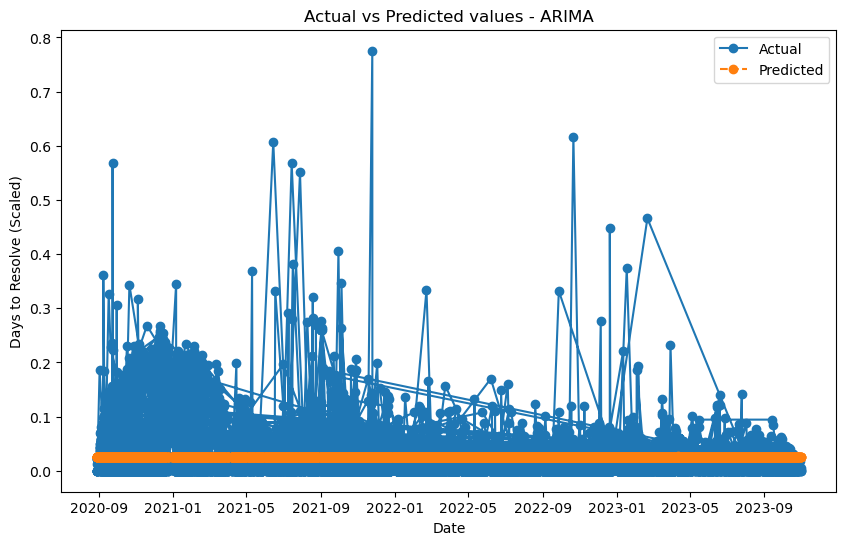

ARIMA Model - MSE: 0.0022186832062659257, MAE: 0.027831529191586546


C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self

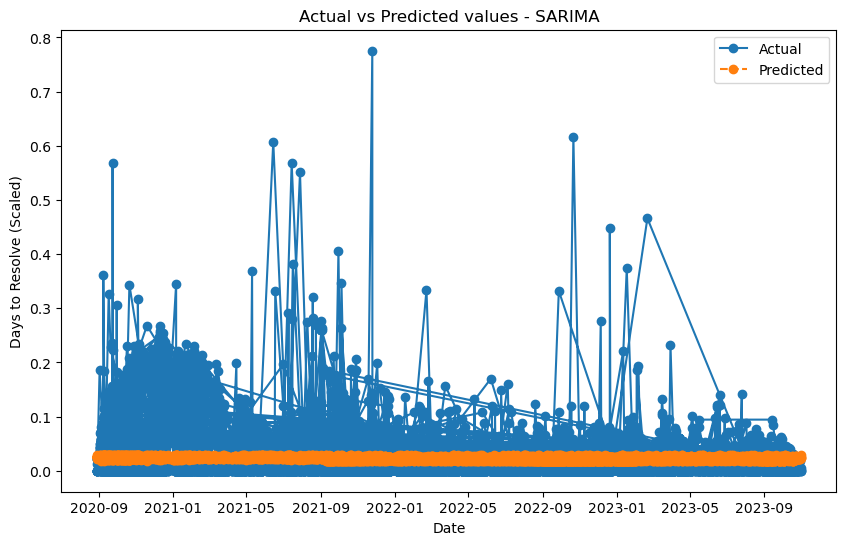

SARIMA Model - MSE: 0.002240864612539748, MAE: 0.027641571607955304


KeyError: "['day_of_week', 'quarter'] not in index"

In [437]:
# Function to split data into train and test sets
def train_test_split_data(data, test_size=0.2):
    split_index = int(len(data) * (1 - test_size))
    train_data, test_data = data[:split_index], data[split_index:]
    return train_data, test_data

# Function to calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE)
def calculate_errors(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    return mse, mae

# Function to plot actual vs predicted values
def plot_actual_vs_predicted(actual, predicted, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(actual.index, actual, label='Actual', marker='o')
    plt.plot(actual.index, predicted, label='Predicted', linestyle='dashed', marker='o')
    plt.title(f'Actual vs Predicted values - {model_name}')
    plt.xlabel('Date')
    plt.ylabel('Days to Resolve (Scaled)')
    plt.legend()
    plt.show()

# LSTM Model
def lstm_model(train, test):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Reshape data for LSTM
    X_train, y_train = np.array(train), np.array(train['days_to_resolve_scaled'])
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    X_test, y_test = np.array(test), np.array(test['days_to_resolve_scaled'])
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Fit the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    # Predictions
    lstm_predictions = model.predict(X_test)

    # Invert scaling for predictions
    lstm_predictions = scaler.inverse_transform(lstm_predictions)

    # Invert scaling for actual values
    actual_values = scaler.inverse_transform(np.array(test['days_to_resolve_scaled']).reshape(-1, 1))

    # Calculate errors
    mse, mae = calculate_errors(actual_values, lstm_predictions)

    # Plot actual vs predicted
    plot_actual_vs_predicted(test['days_to_resolve_scaled'], lstm_predictions, 'LSTM')

    return mse, mae

# ARIMA Model
def arima_model(train, test):
    model = ARIMA(train['days_to_resolve_scaled'], order=(5, 1, 0))
    arima_model = model.fit()

    # Predictions
    arima_predictions = arima_model.forecast(steps=len(test))

    # Calculate errors
    mse, mae = calculate_errors(test['days_to_resolve_scaled'], arima_predictions)

    # Plot actual vs predicted
    plot_actual_vs_predicted(test['days_to_resolve_scaled'], arima_predictions, 'ARIMA')

    return mse, mae

# SARIMA Model
def sarima_model(train, test):
    model = SARIMAX(train['days_to_resolve_scaled'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_model = model.fit()

    # Predictions
    sarima_predictions = sarima_model.get_forecast(steps=len(test)).predicted_mean

    # Calculate errors
    mse, mae = calculate_errors(test['days_to_resolve_scaled'], sarima_predictions)

    # Plot actual vs predicted
    plot_actual_vs_predicted(test['days_to_resolve_scaled'], sarima_predictions, 'SARIMA')

    return mse, mae

# SARIMAX Model
def sarimax_model(train, test):
    exog_train = train[['day_of_week', 'month', 'quarter']]
    exog_test = test[['day_of_week', 'month', 'quarter']]

    model = SARIMAX(train['days_to_resolve_scaled'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=exog_train)
    sarimax_model = model.fit()

    # Predictions
    sarimax_predictions = sarimax_model.get_forecast(steps=len(test), exog=exog_test).predicted_mean

    # Calculate errors
    mse, mae = calculate_errors(test['days_to_resolve_scaled'], sarimax_predictions)

    # Plot actual vs predicted
    plot_actual_vs_predicted(test['days_to_resolve_scaled'], sarimax_predictions, 'SARIMAX')

    return mse, mae

# Split data into train and test sets
train_data, test_data = train_test_split_data(SHUdata_resampled, test_size=0.2)

# LSTM Model
lstm_mse, lstm_mae = lstm_model(train_data, test_data)
print(f'LSTM Model - MSE: {lstm_mse}, MAE: {lstm_mae}')

# ARIMA Model
arima_mse, arima_mae = arima_model(train_data, test_data)
print(f'ARIMA Model - MSE: {arima_mse}, MAE: {arima_mae}')

# SARIMA Model
sarima_mse, sarima_mae = sarima_model(train_data, test_data)
print(f'SARIMA Model - MSE: {sarima_mse}, MAE: {sarima_mae}')

# SARIMAX Model
sarimax_mse, sarimax_mae = sarimax_model(train_data, test_data)
print(f'SARIMAX Model - MSE: {sarimax_mse}, MAE: {sarimax_mae}')


In [439]:
# Split the dataset into training and testing sets
train_size = int(len(SHUdata_resampled) * 0.8)
train, test = SHUdata_resampled[:train_size], SHUdata_resampled[train_size:]

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# LSTM Model
def lstm_prediction(train, test):
    # Extracting the target variable
    y_train = train['days_to_resolve_scaled']
    y_test = test['days_to_resolve_scaled']

    # Reshape data for LSTM
    X_train = np.array(train.drop(['days_to_resolve_scaled'], axis=1))
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    X_test = np.array(test.drop(['days_to_resolve_scaled'], axis=1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=64)

    # Make predictions
    lstm_predictions = model.predict(X_test)
    lstm_predictions = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))

    # Evaluate LSTM model
    lstm_mse = mean_squared_error(test['days_to_resolve'], lstm_predictions)
    lstm_rmse = np.sqrt(lstm_mse)
    lstm_mae = mean_absolute_error(test['days_to_resolve'], lstm_predictions)
    lstm_mape = mean_absolute_percentage_error(test['days_to_resolve'], lstm_predictions)

    return lstm_mse, lstm_rmse, lstm_mae, lstm_mape

# ARIMA Model
def arima_prediction(train, test):
    # Extracting the target variable
    y_train = train['days_to_resolve_scaled']
    y_test = test['days_to_resolve_scaled']

    # Build ARIMA model
    arima_model = ARIMA(y_train, order=(5, 1, 2))
    arima_fit = arima_model.fit()

    # Make predictions
    arima_predictions = arima_fit.forecast(steps=len(test))[0]
    arima_predictions = scaler.inverse_transform(arima_predictions.reshape(-1, 1))

    # Evaluate ARIMA model
    arima_mse = mean_squared_error(test['days_to_resolve'], arima_predictions)
    arima_rmse = np.sqrt(arima_mse)
    arima_mae = mean_absolute_error(test['days_to_resolve'], arima_predictions)
    arima_mape = mean_absolute_percentage_error(test['days_to_resolve'], arima_predictions)

    return arima_mse, arima_rmse, arima_mae, arima_mape

# SARIMA Model
def sarima_prediction(train, test):
    # Extracting the target variable
    y_train = train['days_to_resolve_scaled']
    y_test = test['days_to_resolve_scaled']

    # Build SARIMA model
    sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_fit = sarima_model.fit()

    # Make predictions
    sarima_predictions = sarima_fit.forecast(steps=len(test))
    sarima_predictions = scaler.inverse_transform(sarima_predictions.reshape(-1, 1))

    # Evaluate SARIMA model
    sarima_mse = mean_squared_error(test['days_to_resolve'], sarima_predictions)
    sarima_rmse = np.sqrt(sarima_mse)
    sarima_mae = mean_absolute_error(test['days_to_resolve'], sarima_predictions)
    sarima_mape = mean_absolute_percentage_error(test['days_to_resolve'], sarima_predictions)

    return sarima_mse, sarima_rmse, sarima_mae, sarima_mape

# SARIMAX Model
def sarimax_prediction(train, test):
    # Extracting the target variable
    y_train = train['days_to_resolve_scaled']
    y_test = test['days_to_resolve_scaled']

    # Build SARIMAX model
    sarimax_model = SARIMAX(y_train, exog=train[['day_of_week', 'month', 'quarter']], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarimax_fit = sarimax_model.fit()

    # Make predictions
    sarimax_predictions = sarimax_fit.forecast(steps=len(test), exog=test[['day_of_week', 'month', 'quarter']])
    sarimax_predictions = scaler.inverse_transform(sarimax_predictions.reshape(-1, 1))

    # Evaluate SARIMAX model
    sarimax_mse = mean_squared_error(test['days_to_resolve'], sarimax_predictions)
    sarimax_rmse = np.sqrt(sarimax_mse)
    sarimax_mae = mean_absolute_error(test['days_to_resolve'], sarimax_predictions)
    sarimax_mape = mean_absolute_percentage_error(test['days_to_resolve'], sarimax_predictions)

    return sarimax_mse, sarimax_rmse, sarimax_mae, sarimax_mape

# Perform predictions and evaluate models
lstm_mse, lstm_rmse, lstm_mae, lstm_mape = lstm_prediction(train, test)
arima_mse, arima_rmse, arima_mae, arima_mape = arima_prediction(train, test)
sarima_mse, sarima_rmse, sarima_mae, sarima_mape = sarima_prediction(train, test)
sarimax_mse, sarimax_rmse, sarimax_mae, sarimax_mape = sarimax_prediction(train, test)

# Display the results
print("LSTM Metrics:")
print(f"MSE: {lstm_mse}, RM


SyntaxError: unterminated string literal (detected at line 119) (898613108.py, line 119)

C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self

Actual Values
date_logged
2023-01-19 09:05:00    0.026415
2023-03-17 12:34:00    0.033962
2023-03-22 15:55:00    0.030189
2023-03-29 13:21:00    0.035849
2023-04-03 12:26:00    0.032075
                         ...   
2023-10-18 05:38:00    0.026415
2023-10-18 10:48:00    0.026415
2023-10-18 11:16:00    0.028302
2023-10-18 13:57:00    0.026415
2023-10-18 22:06:00    0.028302
Name: days_to_resolve_scaled, Length: 15403, dtype: float64

Predicted Values
date_logged
2023-01-19 09:05:00    0.021599
2023-03-17 12:34:00    0.024305
2023-03-22 15:55:00    0.022298
2023-03-29 13:21:00    0.022034
2023-04-03 12:26:00    0.021319
                         ...   
2023-10-18 05:38:00    0.030235
2023-10-18 10:48:00    0.030235
2023-10-18 11:16:00    0.030235
2023-10-18 13:57:00    0.030235
2023-10-18 22:06:00    0.030235
Name: predicted_mean, Length: 15403, dtype: float64


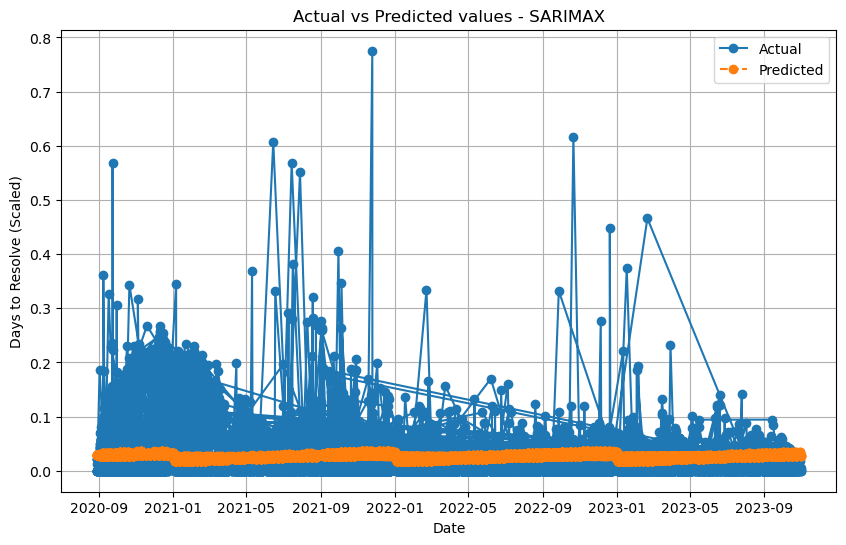

SARIMAX Model - MSE: 0.0021829642972466183, RMSE: 0.046722203471653796 MAE: 0.028092155260369674


In [263]:
# Function to split data into train and test sets
def train_test_split_data(data, test_size=0.2):
    split_index = int(len(data) * (1 - test_size))
    train_data, test_data = data[:split_index], data[split_index:]
    return train_data, test_data

# Function to calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE)
def calculate_errors(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    return mse,rmse, mae

# Function to plot actual vs predicted values
def plot_actual_vs_predicted(actual, predicted, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(actual.index, actual, label='Actual', marker='o')
    plt.plot(actual.index, predicted, label='Predicted', linestyle='dashed', marker='o')
    plt.title(f'Actual vs Predicted values - {model_name}')
    plt.xlabel('Date')
    plt.ylabel('Days to Resolve (Scaled)')
    plt.legend()
    plt.grid(True)
    plt.show()


# SARIMAX Model
def sarimax_model(train, test):
    exog_train = train[['day_of_week', 'month', 'quarter']]
    exog_test = test[['day_of_week', 'month', 'quarter']]

    model = SARIMAX(train['days_to_resolve_scaled'], order=(4, 1, 2), seasonal_order=(4, 0, 3, 12), exog=exog_train)
    sarimax_model = model.fit()

    # Predictions
    sarimax_predictions = sarimax_model.get_forecast(steps=len(test), exog=exog_test).predicted_mean
    sarimax_predictions.index = test.index
    print("Actual Values")
    print(test['days_to_resolve_scaled'])
    print("\nPredicted Values")
    print(sarimax_predictions)

    # Calculate errors
    mse,rmse, mae = calculate_errors(test['days_to_resolve_scaled'], sarimax_predictions)

    # Plot actual vs predicted
    plot_actual_vs_predicted(test['days_to_resolve_scaled'], sarimax_predictions, 'SARIMAX')

    return mse, rmse, mae

# Split data into train and test sets
train_data, test_data = train_test_split_data(SHUdata_resampled, test_size=0.2)

# SARIMAX Model
sarimax_mse, sarimax_rmse, sarimax_mae = sarimax_model(train_data, test_data)
print(f'SARIMAX Model - MSE: {sarimax_mse}, RMSE: {sarimax_rmse} MAE: {sarimax_mae}')

C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SA2404\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self

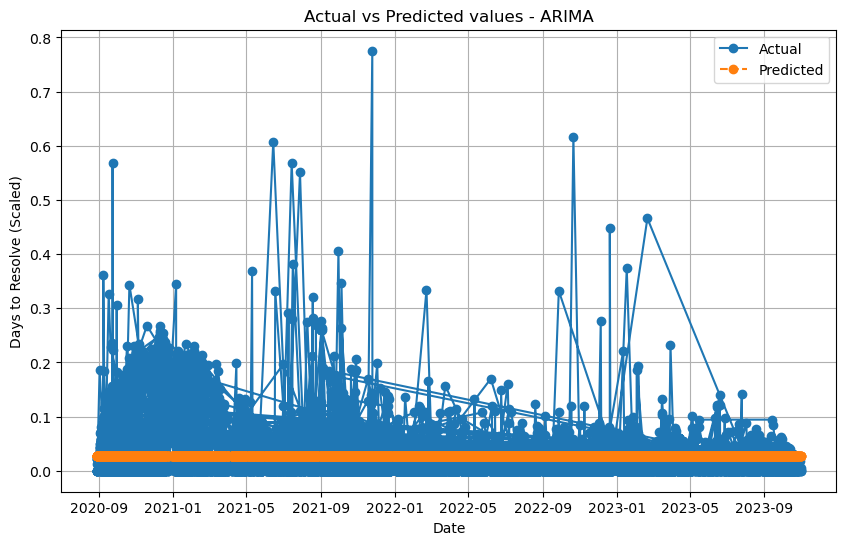

ARIMA Model - MSE: 0.0022143808153496916, RMSE: 0.04705720790006236, MAE: 0.02815102880588389


In [264]:
# Function to split data into train and test sets
def train_test_split_data(data, test_size=0.2):
    split_index = int(len(data) * (1 - test_size))
    train_data, test_data = data[:split_index], data[split_index:]
    return train_data, test_data

# Function to calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE)
def calculate_errors(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    return mse,rmse, mae

# Function to plot actual vs predicted values
def plot_actual_vs_predicted(actual, predicted, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(actual.index, actual, label='Actual', marker='o')
    plt.plot(actual.index, predicted, label='Predicted', linestyle='dashed', marker='o')
    plt.title(f'Actual vs Predicted values - {model_name}')
    plt.xlabel('Date')
    plt.ylabel('Days to Resolve (Scaled)')
    plt.legend()
    plt.grid(True)
    plt.show()

# ARIMA Model
def arima_model(train, test):
    model = ARIMA(train['days_to_resolve_scaled'], order=(4, 1, 2), seasonal_order=(4, 0, 3,12))
    arima_model = model.fit()

    # Predictions
    arima_predictions = arima_model.forecast(steps=len(test))

    # Calculate errors
    mse,rmse, mae = calculate_errors(test['days_to_resolve_scaled'], arima_predictions)

    # Plot actual vs predicted
    plot_actual_vs_predicted(test['days_to_resolve_scaled'], arima_predictions, 'ARIMA')

    return mse, rmse, mae


# Split data into train and test sets
train_data, test_data = train_test_split_data(SHUdata_resampled, test_size=0.2)

# ARIMA Model
arima_mse, arima_rmse, arima_mae = arima_model(train_data, test_data)
print(f'ARIMA Model - MSE: {arima_mse}, RMSE: {arima_rmse}, MAE: {arima_mae}')

482/482 [==============================] - 2s 3ms/step


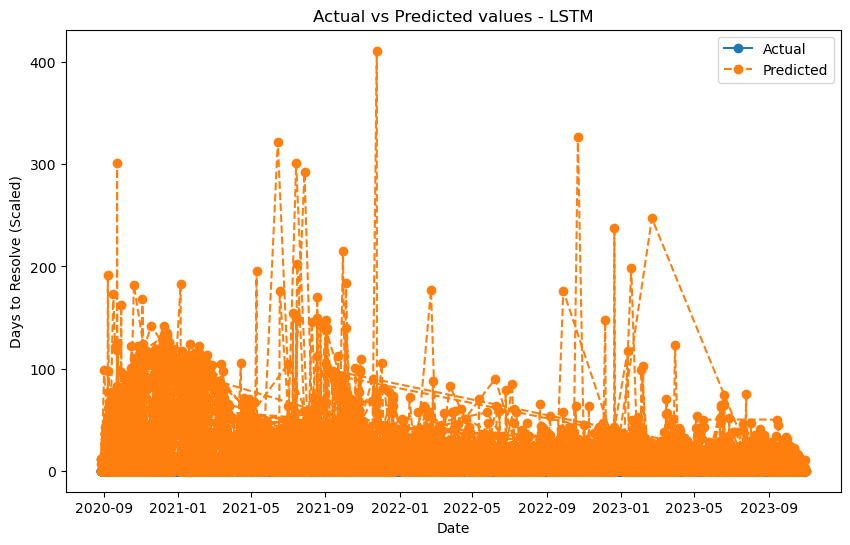

LSTM Model - MSE: 0.0021453411681756356, RMSE: 0.04631782775752373 MAE: 0.03583129046959212


In [265]:
# Function to split data into train and test sets
def train_test_split_data(data, test_size=0.2):
    split_index = int(len(data) * (1 - test_size))
    train_data, test_data = data[:split_index], data[split_index:]
    return train_data, test_data

# Function to calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE)
def calculate_errors(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    return mse,rmse, mae

# Function to plot actual vs predicted values
def plot_actual_vs_predicted(actual, predicted, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(actual.index, actual, label='Actual', marker='o')
    plt.plot(actual.index, predicted, label='Predicted', linestyle='dashed', marker='o')
    plt.title(f'Actual vs Predicted values - {model_name}')
    plt.xlabel('Date')
    plt.ylabel('Days to Resolve (Scaled)')
    plt.legend()
    plt.show()

# LSTM Model
def lstm_model(train, test):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Reshape data for LSTM
    X_train, y_train = np.array(train), np.array(train['days_to_resolve_scaled'])
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    X_test, y_test = np.array(test), np.array(test['days_to_resolve_scaled'])
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Fit the model
    model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    # Predictions
    lstm_predictions = model.predict(X_test)

    # Invert scaling for predictions
    lstm_predictions = scaler.inverse_transform(lstm_predictions)

    # Invert scaling for actual values
    actual_values = scaler.inverse_transform(np.array(test['days_to_resolve_scaled']).reshape(-1, 1))

    # Calculate errors
    mse, rmse, mae = calculate_errors(actual_values, lstm_predictions)

    # Plot actual vs predicted
    plot_actual_vs_predicted(test['days_to_resolve_scaled'], lstm_predictions, 'LSTM')

    return mse,rmse, mae
# Split data into train and test sets
train_data, test_data = train_test_split_data(SHUdata_resampled, test_size=0.2)

# LSTM Model
lstm_mse, lstm_rmse, lstm_mae = lstm_model(train_data, test_data)
print(f'LSTM Model - MSE: {lstm_mse}, RMSE: {lstm_rmse} MAE: {lstm_mae}')


In [ ]:
SHUdata.to_csv('SHUdata.csv', index=False)